In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
import tensorflow as tf
import time
import json
from datetime import datetime
from tensorflow import keras
from tensorflow.keras import layers
import tensorflowjs as tfjs
from tool import plot_history, readFile, generData, buildModel, PrintDot

In [17]:
data = []
df = readFile('attractions')
dailyData = pd.json_normalize(readFile('dailies'))

for item in df:
  if item.get('startTime'):
    startTime = item['startTime']
    startTimex = time.mktime(time.strptime(item['date'] + ' ' + item['startTime'], '%Y-%m-%d %H:%M:%S'))
    endTimex = time.mktime(time.strptime(item['date'] + ' ' + item['endTime'], '%Y-%m-%d %H:%M:%S'))
    countTimex = endTimex - startTimex
    date = item['date']

    dailyItem = dailyData.query("date=='" + date + "'")
    dailyItem = json.loads(dailyItem.to_json(orient="records"))
    if dailyItem[0]:
      parkValue = dailyItem[0]['value']
      for row in item['rows']:
        timex = (row[0] - startTimex)/countTimex
        data.append({"timex": timex, "value": row[1], "avg": parkValue, "date": item['date'], "name": item["name"]})
        data.append({"timex": timex, "value": row[1], "avg": item['value'], "date": item['date'], "name": item["name"], "parkValue": parkValue})


In [18]:
dataset = pd.json_normalize(data)
dataset = dataset[['timex', 'value', 'avg', 'name']]
dataset['avg'] = dataset['avg'] / 875
dataset['value'] = dataset['value'] / 150

allData = dataset[1:]

In [19]:
def start(name):
  [normed_train_data, normed_test_data, train_dataset, train_labels, test_labels] = generData(allData, name)

  model = buildModel(train_dataset)
    
  model.summary()

  example_batch = normed_train_data[:10]
  example_result = model.predict(example_batch)
  # return


  EPOCHS = 500

  history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split = 0.2, verbose=0,
    callbacks=[PrintDot()])

  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  hist.tail()

  plot_history(history)

  model = buildModel(train_dataset)
  # patience 值用来检查改进 epochs 的数量
  early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
  history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])
  plot_history(history)

  model.save('../model/' + name + '.h5')
  tfjs.converters.save_keras_model(model, '../web-model/' + name)

  testData = pd.json_normalize([])
  testData['timex'] =  pd.RangeIndex(1, 100) / 100
  testData['avg'] = 0.9
  print(testData.head())

  test_predictions = model.predict(testData).flatten()
  print(test_predictions)
  testData['value'] = test_predictions # * 150

  plot_cols = ['timex', 'value']
  plot_features = testData[plot_cols]
  plot_features.index = testData['timex']
  _ = plot_features.plot()

  # 做预测
  test_predictions = model.predict(normed_test_data).flatten()

  plt.scatter(test_labels, test_predictions)
  plt.xlabel('True Values [Total]')
  plt.ylabel('Predictions [Total]')
  plt.axis('equal')
  plt.axis('square')
  plt.xlim([0,plt.xlim()[1]])
  plt.ylim([0,plt.ylim()[1]])
  _ = plt.plot([-1, 1], [-1, 1])

timex    33727
value    33727
avg      33727
name     33727
dtype: int64
         timex     value       avg
4645  0.007937  0.020000  0.010286
4646  0.015873  0.033333  0.504000
4647  0.015873  0.033333  0.010286
4648  0.023810  0.033333  0.504000
4649  0.023810  0.033333  0.010286
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 64)                192       
                                                                 
 dense_85 (Dense)            (None, 64)                4160      
                                                                 
 dense_86 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
_________________________________________________________________
1/1 [===========================

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

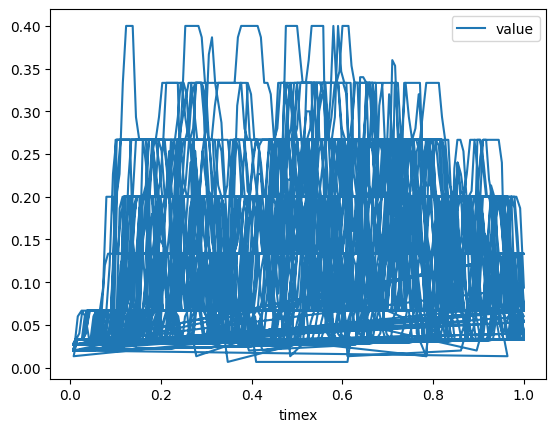

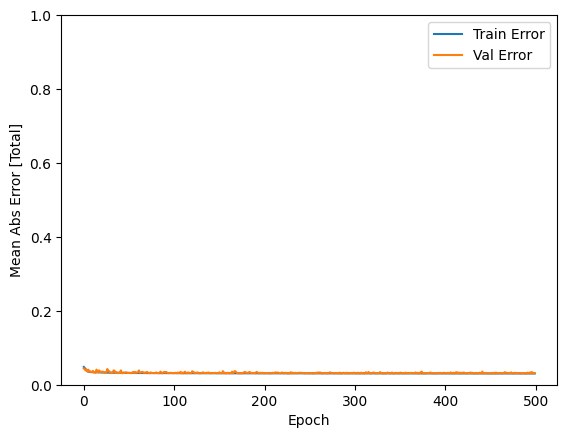

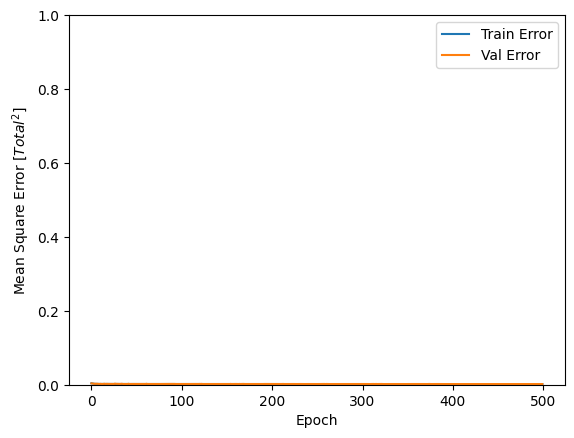

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



........................

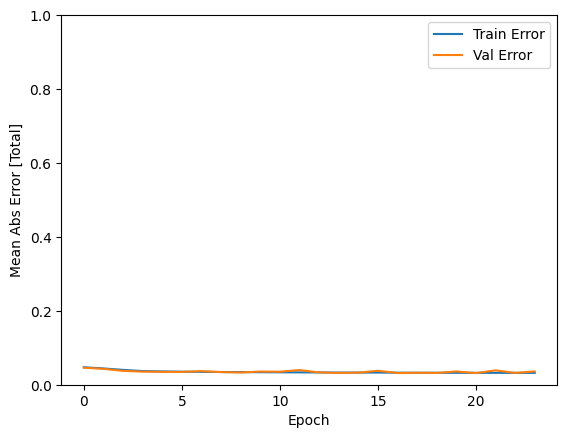

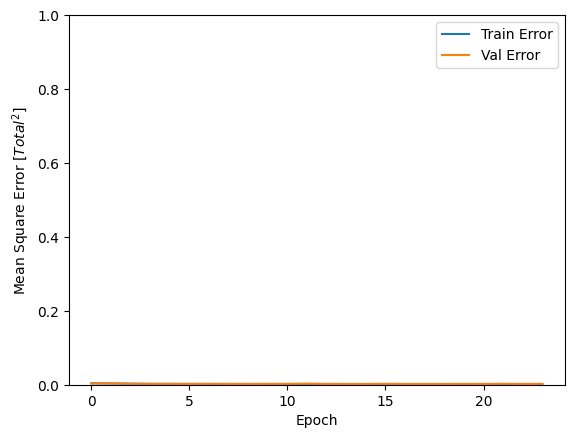

   timex  avg
0   0.01  0.9
1   0.02  0.9
2   0.03  0.9
3   0.04  0.9
4   0.05  0.9
4/4 [==============================] - 0s 927us/step
[0.03684917 0.04273269 0.04918242 0.05671975 0.06453551 0.07235122
 0.08016696 0.08798268 0.09638804 0.10548661 0.11458521 0.12368914
 0.13280669 0.14183003 0.15045723 0.15689439 0.1622613  0.16721104
 0.17217064 0.17642143 0.17852256 0.18062367 0.18257515 0.18351892
 0.1844627  0.18530771 0.18613957 0.18697146 0.18780331 0.18863517
 0.18946701 0.1902989  0.19113076 0.19278023 0.1947284  0.19667655
 0.19862473 0.20057291 0.20252106 0.20446923 0.20641741 0.20836556
 0.21031375 0.21226192 0.2142101  0.21615827 0.21810643 0.2200546
 0.22200277 0.22372131 0.22443374 0.22483438 0.22494894 0.2250635
 0.22517808 0.22529262 0.22540718 0.22552177 0.22562617 0.22572383
 0.2258215  0.22590965 0.225938   0.22597185 0.22570002 0.22540322
 0.2251064  0.22469434 0.22426048 0.22382882 0.223407   0.22299694
 0.22258443 0.22202331 0.22136703 0.21913901 0.21627751 0.212

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

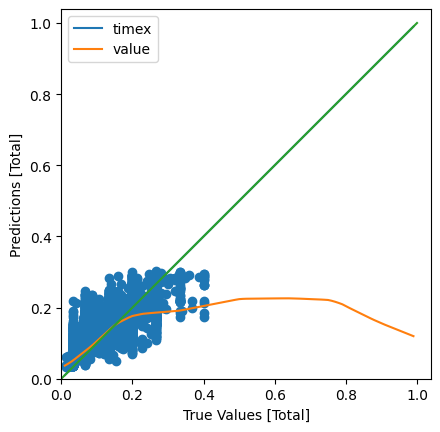

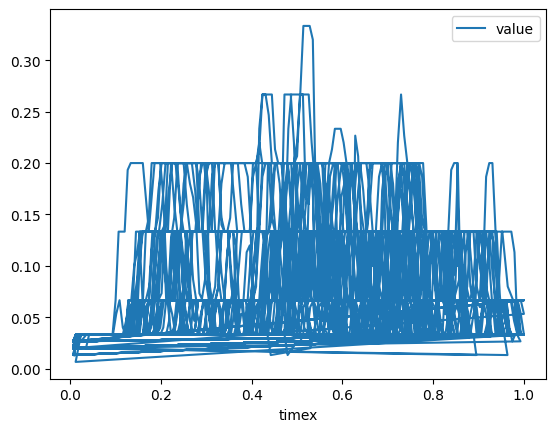

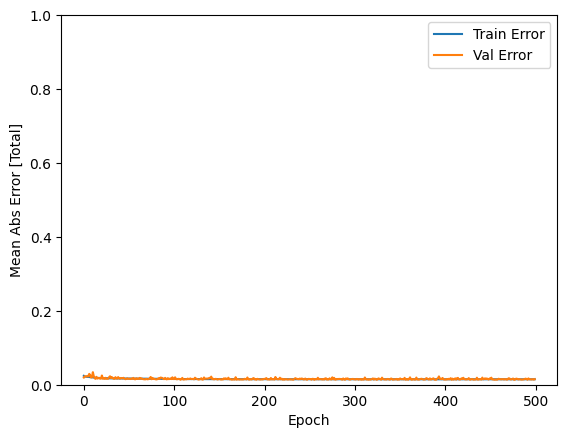

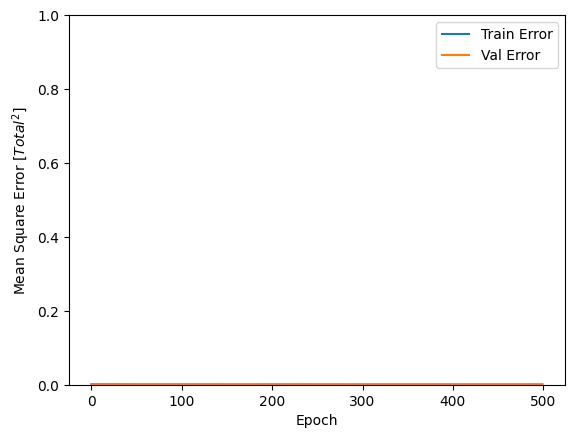

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



............................................................

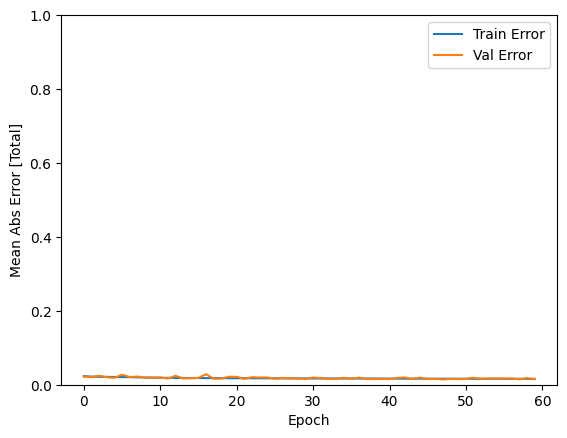

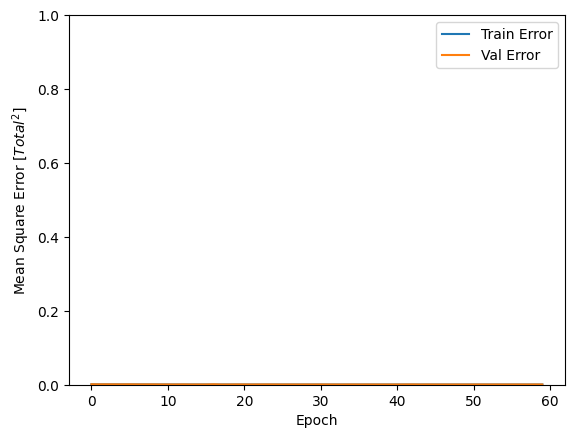

   timex  avg
0   0.01  0.9
1   0.02  0.9
2   0.03  0.9
3   0.04  0.9
4   0.05  0.9
4/4 [==============================] - 0s 3ms/step
[0.02011515 0.02141328 0.02271141 0.02400956 0.02530771 0.02660582
 0.02790396 0.02920212 0.03050024 0.03179838 0.03327372 0.03553819
 0.03850778 0.04201416 0.04564083 0.04926745 0.05289412 0.05652077
 0.06014742 0.063651   0.06673109 0.06833027 0.06854492 0.06809413
 0.06764331 0.06719252 0.06674173 0.0663199  0.06605517 0.0657941
 0.06555394 0.06531379 0.06507362 0.06483346 0.06494719 0.06768209
 0.07072997 0.07429422 0.07834578 0.08240028 0.08645477 0.09080772
 0.09544379 0.1001801  0.10491642 0.10965273 0.11438903 0.11912534
 0.12386166 0.12851563 0.12918058 0.12814125 0.12703823 0.12544954
 0.12360437 0.12184879 0.12016804 0.11848729 0.11680655 0.11551252
 0.11432239 0.11338843 0.11259948 0.11181054 0.11103634 0.11032718
 0.10963558 0.10892375 0.10820948 0.10753693 0.10633084 0.10481964
 0.10310641 0.1003213  0.09753618 0.09475108 0.09196597 0.0891

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

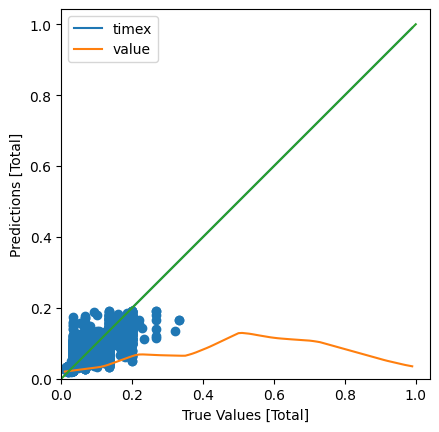

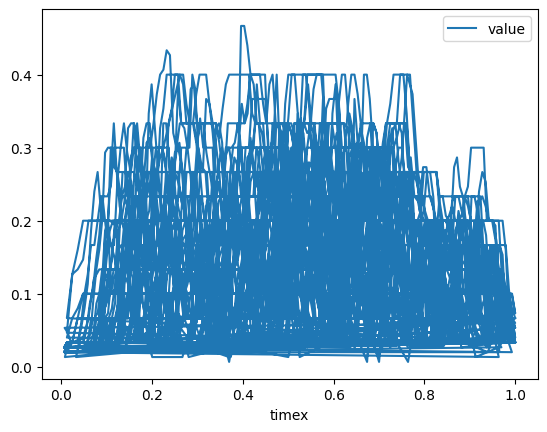

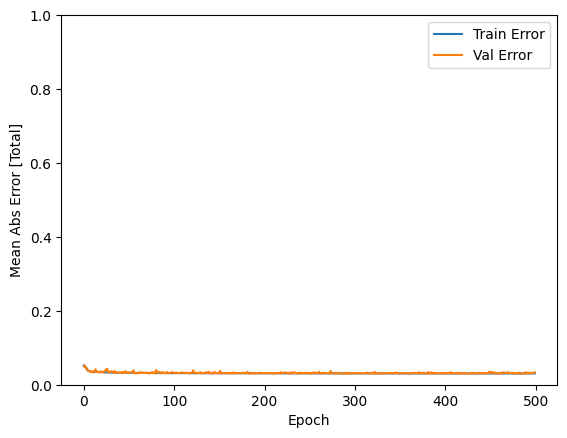

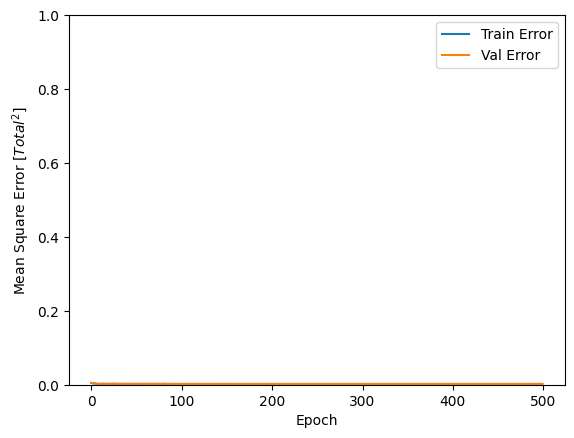

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



...................................

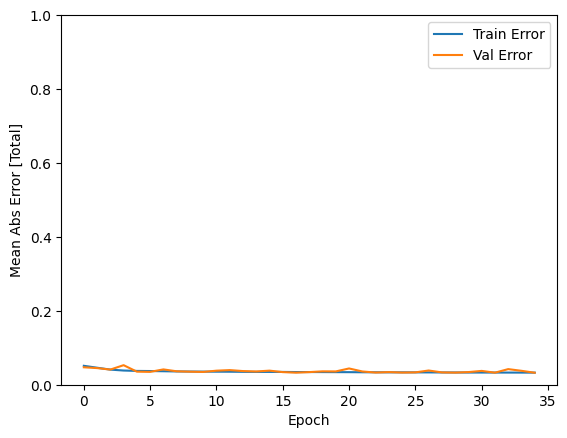

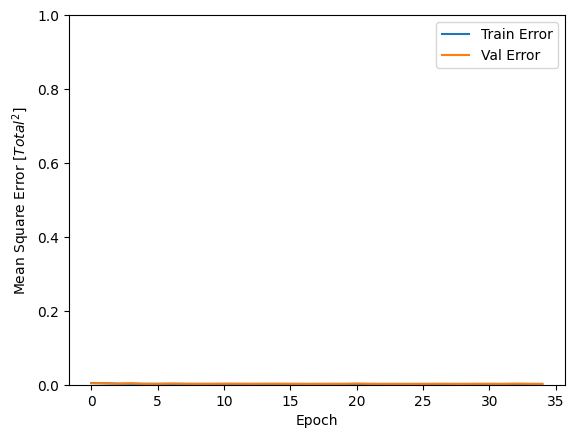

   timex  avg
0   0.01  0.9
1   0.02  0.9
2   0.03  0.9
3   0.04  0.9
4   0.05  0.9
4/4 [==============================] - 0s 2ms/step
[0.01505838 0.02212351 0.0296599  0.03719637 0.04473279 0.05262556
 0.06085741 0.06920251 0.07754762 0.08619176 0.09515414 0.10411653
 0.11307889 0.1219828  0.13071766 0.13944969 0.1481426  0.15651898
 0.16463746 0.17101601 0.17447507 0.17605731 0.17763954 0.17922176
 0.18080083 0.18231711 0.18383342 0.1853497  0.18686602 0.18838233
 0.18993491 0.19155896 0.19351712 0.19590701 0.19830102 0.20069501
 0.2034935  0.20667505 0.2098566  0.21302834 0.21619499 0.21936166
 0.22252831 0.225695   0.22886163 0.23191932 0.23477453 0.23762107
 0.24024722 0.24132219 0.24169609 0.24177662 0.24053708 0.23908019
 0.23765737 0.23624972 0.23484203 0.23343438 0.23202673 0.22974566
 0.22717303 0.22460037 0.22202772 0.21945508 0.2168041  0.21399654
 0.211189   0.20838144 0.2055739  0.2019692  0.19773032 0.1934914
 0.18925253 0.18498746 0.18048537 0.1759406  0.17139581 0.1667

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

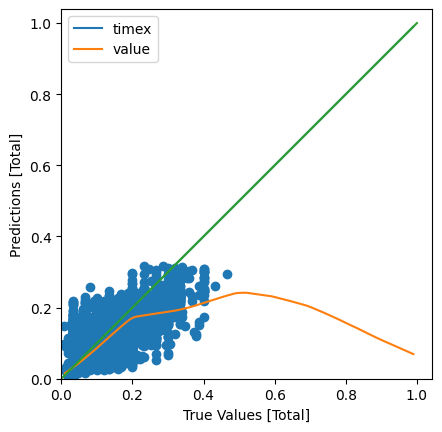

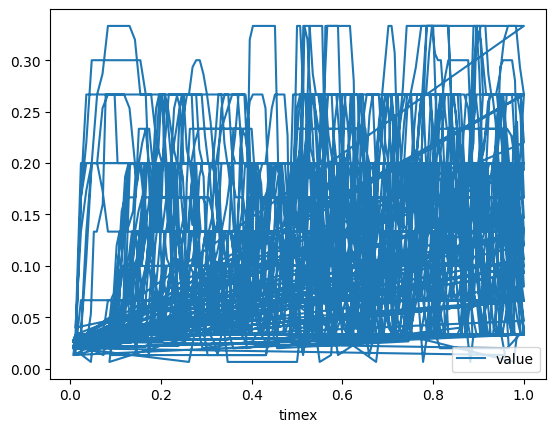

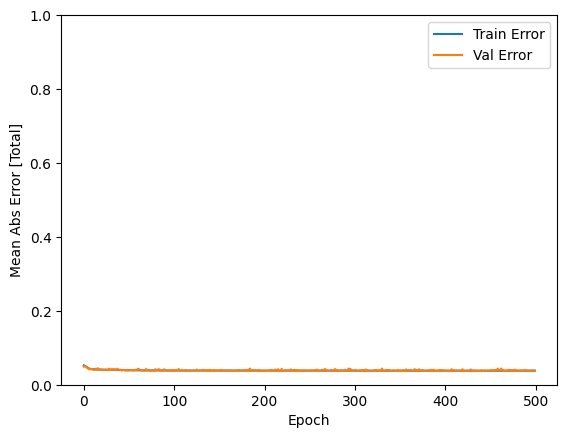

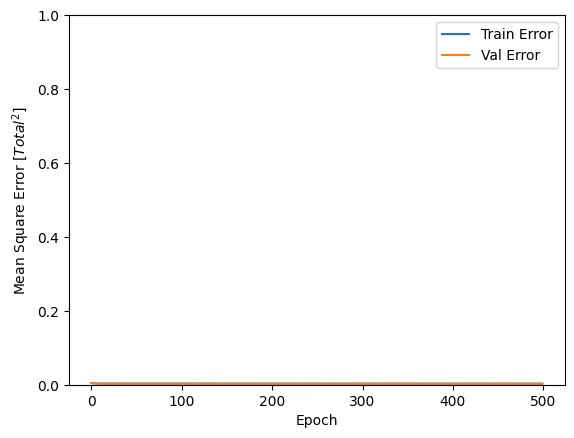

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



...............................

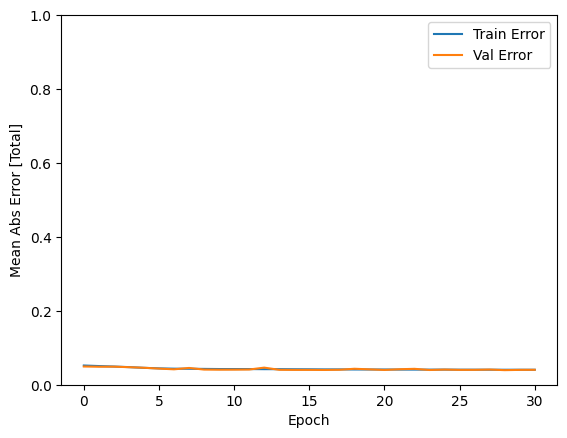

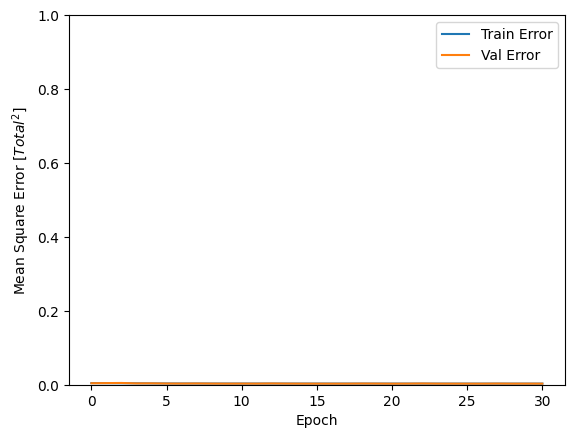

   timex  avg
0   0.01  0.9
1   0.02  0.9
2   0.03  0.9
3   0.04  0.9
4   0.05  0.9
4/4 [==============================] - 0s 2ms/step
[0.02143152 0.02647108 0.03172262 0.03699506 0.04226752 0.04753996
 0.05281239 0.05899995 0.06519292 0.07138586 0.07757884 0.0837718
 0.08965825 0.09488085 0.10010346 0.10533531 0.11058636 0.11574641
 0.12090645 0.12382964 0.12573025 0.1275253  0.1283256  0.12874088
 0.12913966 0.12953848 0.12993726 0.13033608 0.13073486 0.13113366
 0.13153246 0.13193731 0.13235047 0.13276455 0.13317865 0.13359278
 0.13443011 0.13582689 0.13742012 0.13901338 0.14060664 0.14219987
 0.14379314 0.1453864  0.14697966 0.1485729  0.15016615 0.15175942
 0.15335268 0.15494594 0.15653941 0.15813291 0.1591844  0.16016161
 0.16113886 0.16211611 0.16309336 0.16407058 0.16504782 0.16602507
 0.16698954 0.1679507  0.16891187 0.16987303 0.1708342  0.17179538
 0.17274672 0.1736894  0.17463207 0.17551842 0.17630054 0.17706162
 0.17782271 0.17733386 0.17586571 0.1743255  0.17278522 0.1712

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

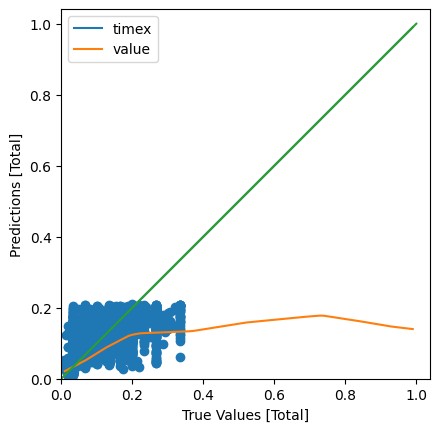

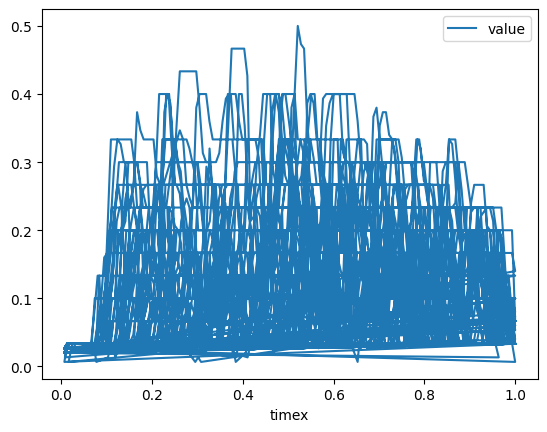

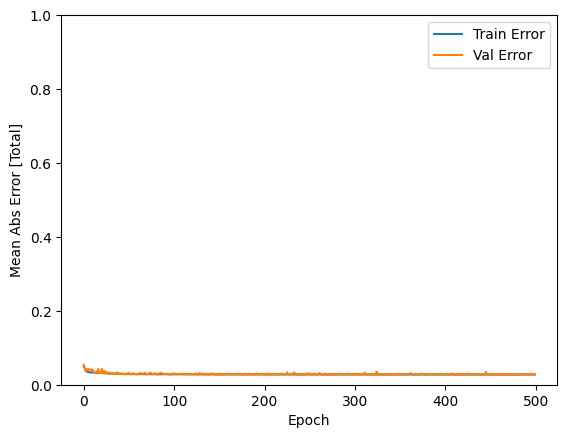

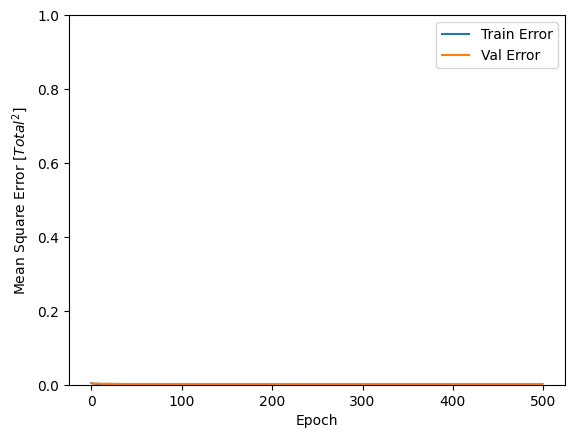

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



...........................

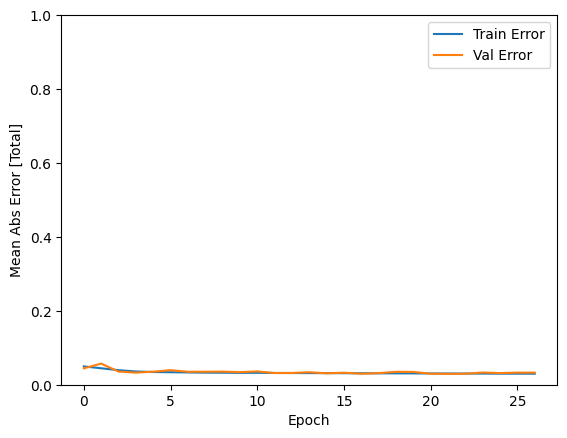

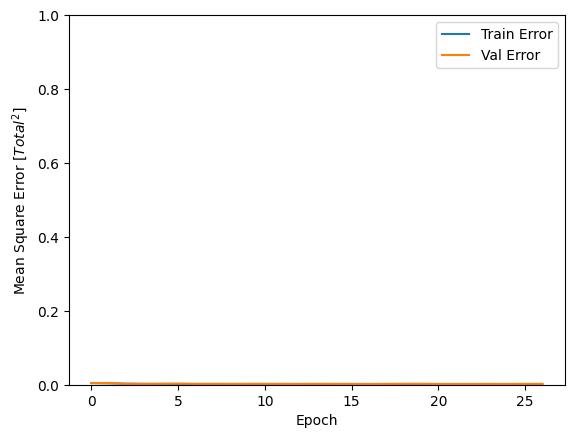

   timex  avg
0   0.01  0.9
1   0.02  0.9
2   0.03  0.9
3   0.04  0.9
4   0.05  0.9
4/4 [==============================] - 0s 1ms/step
[0.0060996  0.01174267 0.01738573 0.02302882 0.02867182 0.03431497
 0.04003552 0.04760141 0.05542552 0.06329224 0.07241421 0.08170616
 0.09130108 0.10089608 0.11049107 0.12008603 0.12959036 0.13870619
 0.1477845  0.15526325 0.16138652 0.16750988 0.17135088 0.17338866
 0.17542642 0.17746417 0.17950195 0.1815397  0.18357745 0.18563864
 0.18761864 0.18940723 0.19144781 0.19348842 0.19552958 0.19778539
 0.20063576 0.20348608 0.20633644 0.20920634 0.21210271 0.21499905
 0.21789542 0.22081956 0.22376305 0.2267065  0.22964999 0.23252046
 0.23518473 0.23781112 0.24039564 0.24298012 0.24301851 0.2423932
 0.24176115 0.24112517 0.24048907 0.23985308 0.23921704 0.238581
 0.23794496 0.23730895 0.23629433 0.23488274 0.23347113 0.23185277
 0.23020002 0.22854814 0.22689632 0.2252303  0.22356424 0.2218982
 0.2198335  0.21549234 0.21124083 0.20634997 0.2012534  0.1961812

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

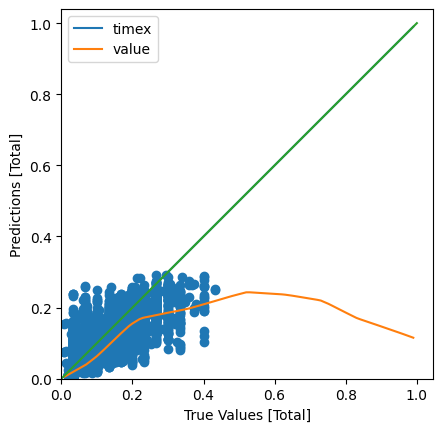

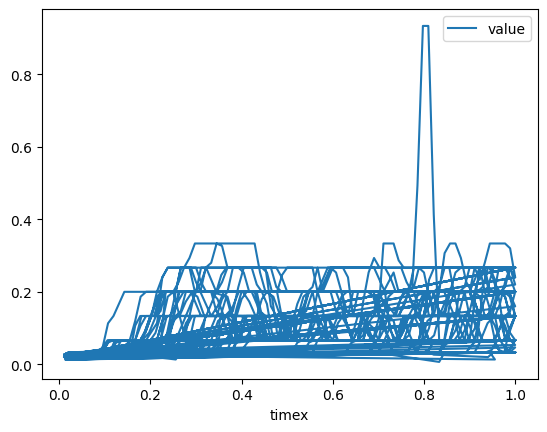

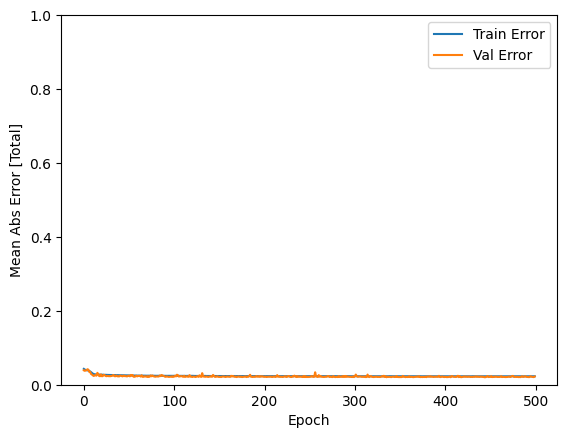

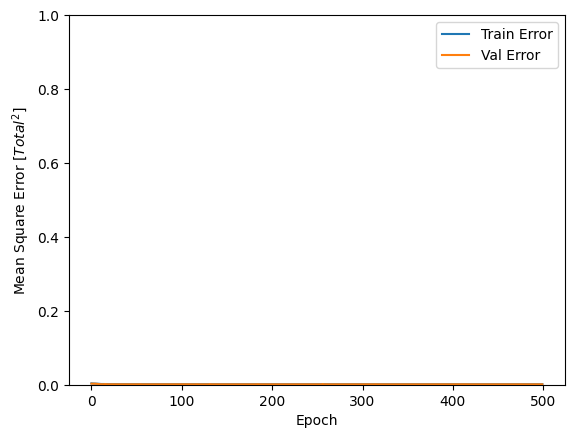

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



............................

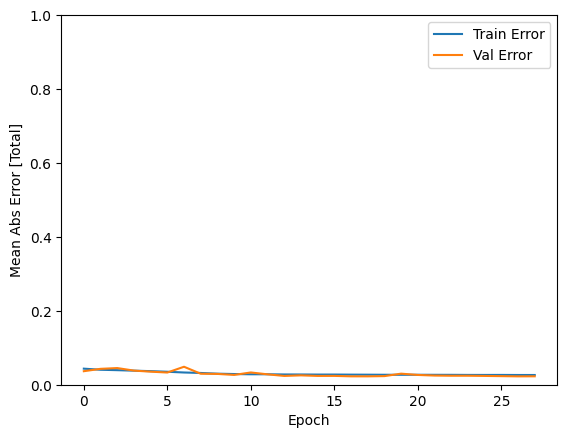

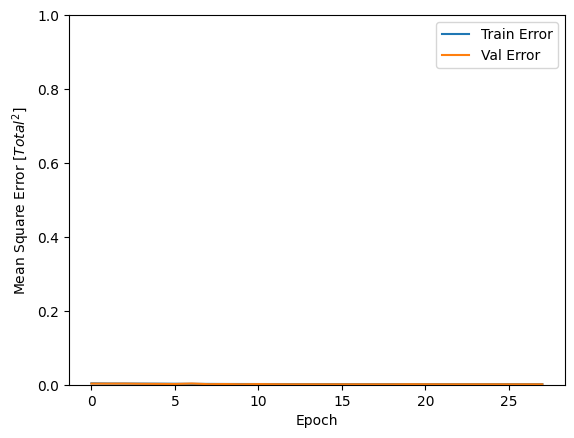

   timex  avg
0   0.01  0.9
1   0.02  0.9
2   0.03  0.9
3   0.04  0.9
4   0.05  0.9
4/4 [==============================] - 0s 1ms/step
[0.01659209 0.01775746 0.01896487 0.0202728  0.02158071 0.02288862
 0.02419653 0.02550444 0.02678044 0.02803963 0.02929883 0.03075982
 0.03243877 0.0341178  0.0359184  0.03796387 0.0413418  0.04653125
 0.05277517 0.05937809 0.06627497 0.07317184 0.08006871 0.08696558
 0.09391464 0.1010078  0.108101   0.11519735 0.12231353 0.1294298
 0.13654602 0.1436622  0.15010919 0.15455261 0.15806362 0.15937679
 0.16042215 0.16093302 0.16121478 0.16145937 0.16170391 0.16191599
 0.16189551 0.16187505 0.16184479 0.16180101 0.16175729 0.16171354
 0.1616698  0.16162604 0.16158235 0.1615386  0.16149482 0.16145109
 0.16140732 0.16136359 0.16131985 0.16127615 0.16123241 0.16118865
 0.16114488 0.16110115 0.16105738 0.16101368 0.16096993 0.16092615
 0.16088241 0.1608387  0.16079496 0.16110769 0.16163668 0.16218784
 0.16273902 0.16329017 0.16384135 0.16439256 0.16494374 0.1654

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

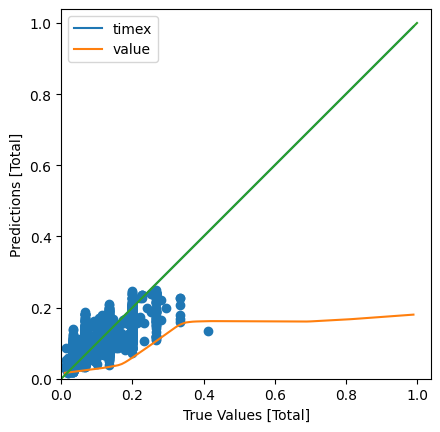

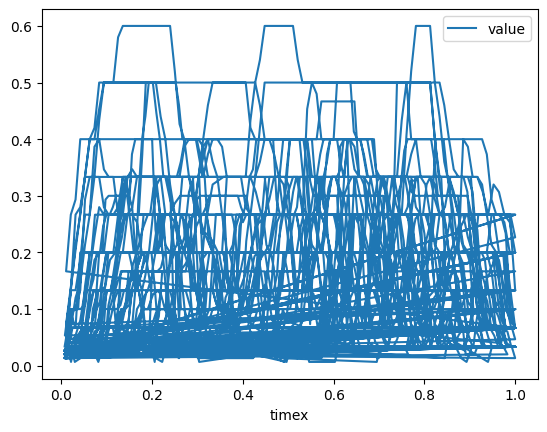

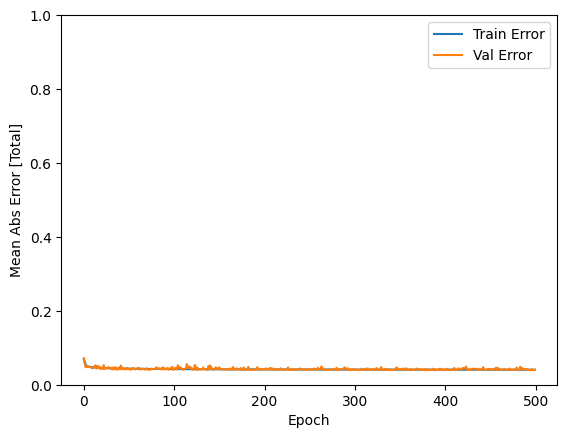

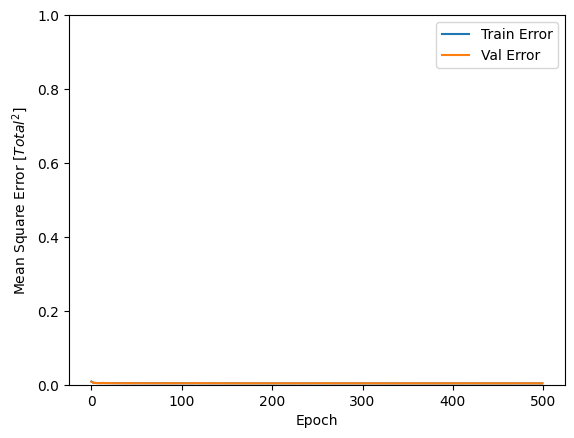

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



.........................

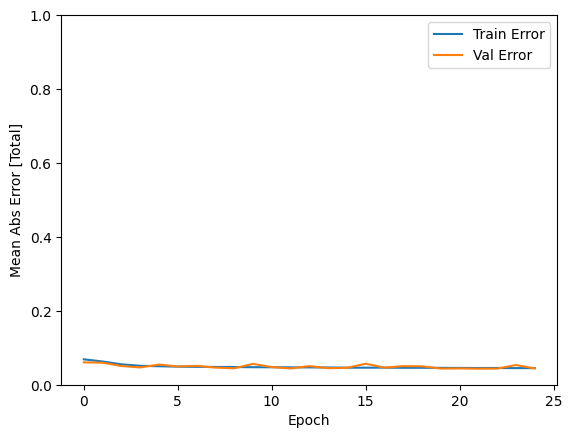

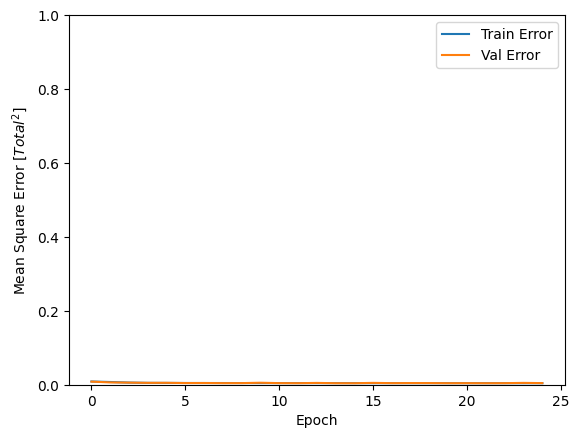

   timex  avg
0   0.01  0.9
1   0.02  0.9
2   0.03  0.9
3   0.04  0.9
4   0.05  0.9
4/4 [==============================] - 0s 963us/step
[-8.40837508e-03 -2.19427049e-04  7.97113776e-03  1.62257105e-02
  2.47596800e-02  3.32936645e-02  4.18276861e-02  5.03616594e-02
  5.88956363e-02  6.74296394e-02  7.59636164e-02  8.45994502e-02
  9.32758152e-02  1.01952195e-01  1.10628575e-01  1.19304970e-01
  1.27981335e-01  1.35622233e-01  1.38879567e-01  1.42112657e-01
  1.45192608e-01  1.47488922e-01  1.49198115e-01  1.50870755e-01
  1.52543336e-01  1.54215977e-01  1.55888632e-01  1.57561272e-01
  1.59233868e-01  1.60906523e-01  1.62579149e-01  1.64251775e-01
  1.65924415e-01  1.67597055e-01  1.69269681e-01  1.70942307e-01
  1.72614962e-01  1.74287587e-01  1.76004127e-01  1.77790284e-01
  1.79576471e-01  1.81362599e-01  1.83148831e-01  1.84934989e-01
  1.86721176e-01  1.88507304e-01  1.90293536e-01  1.92133754e-01
  1.93998724e-01  1.95863694e-01  1.97728693e-01  1.99601024e-01
  2.01475456e-01  

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

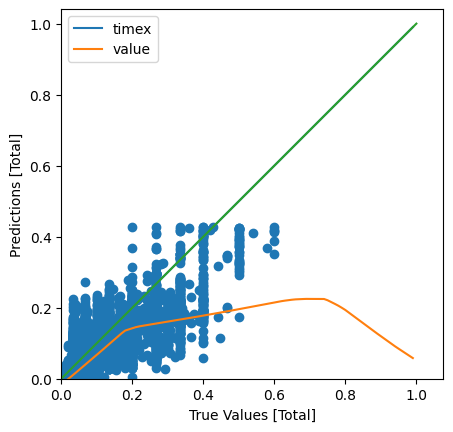

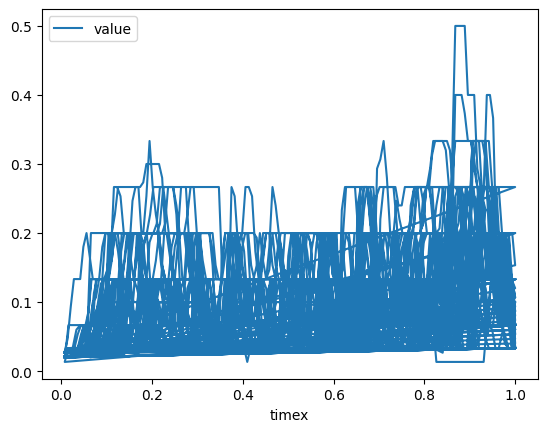

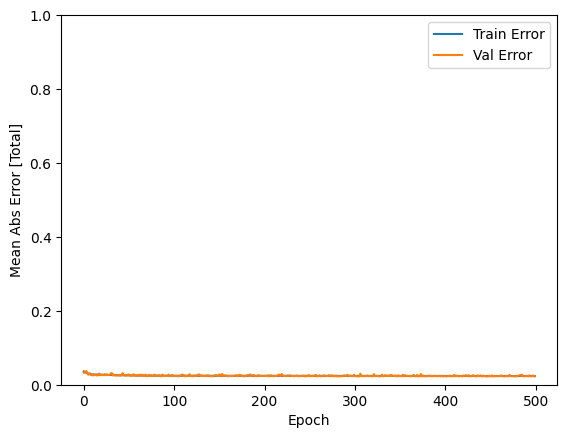

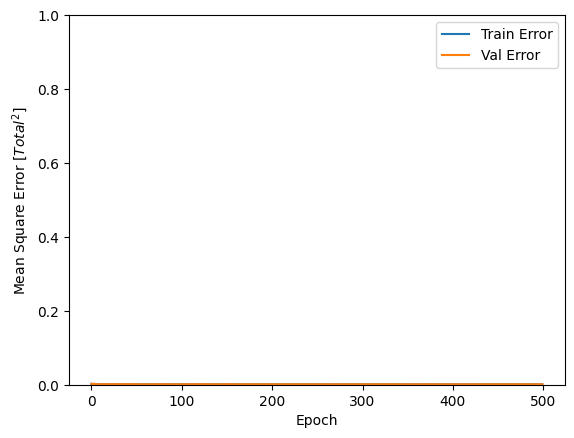

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



......................................

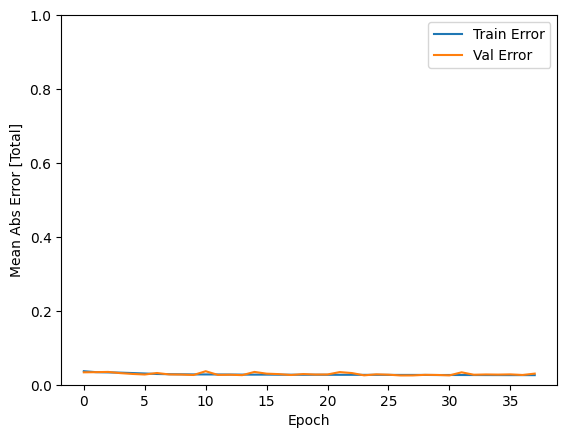

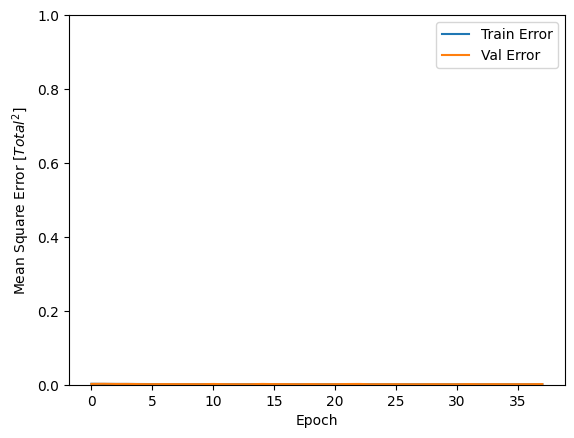

   timex  avg
0   0.01  0.9
1   0.02  0.9
2   0.03  0.9
3   0.04  0.9
4   0.05  0.9
4/4 [==============================] - 0s 1ms/step
[0.00465716 0.00943392 0.01421946 0.01900502 0.02379058 0.02969328
 0.03673591 0.04467783 0.05355732 0.06271301 0.07186867 0.0803656
 0.08802301 0.09568045 0.10220754 0.10650278 0.11069798 0.11408561
 0.11826601 0.12287611 0.12403883 0.1234175  0.12255132 0.11998536
 0.11674508 0.11350482 0.11026455 0.1070243  0.10378402 0.10054375
 0.0973053  0.09406792 0.09101987 0.08840689 0.08598316 0.08538136
 0.08536965 0.0853579  0.08534618 0.08542197 0.0855248  0.08565997
 0.0857951  0.08593029 0.08606544 0.08625399 0.08646712 0.08673394
 0.08709948 0.087465   0.08783848 0.08863775 0.08943704 0.09038504
 0.09181646 0.09324784 0.09467924 0.09611066 0.09754206 0.09897346
 0.10079552 0.10304777 0.10537925 0.10779346 0.11022029 0.11270063
 0.11518165 0.1176554  0.12011439 0.12257337 0.12503234 0.12749135
 0.12995031 0.1324093  0.13486826 0.13732725 0.13978624 0.1422

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

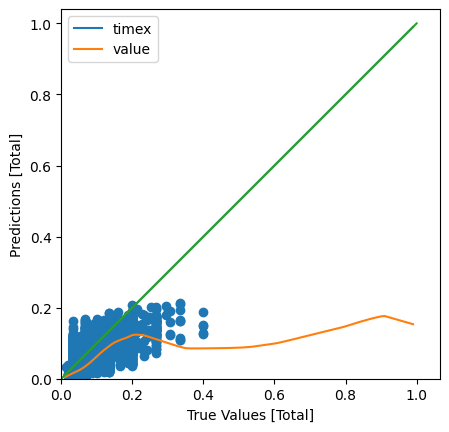

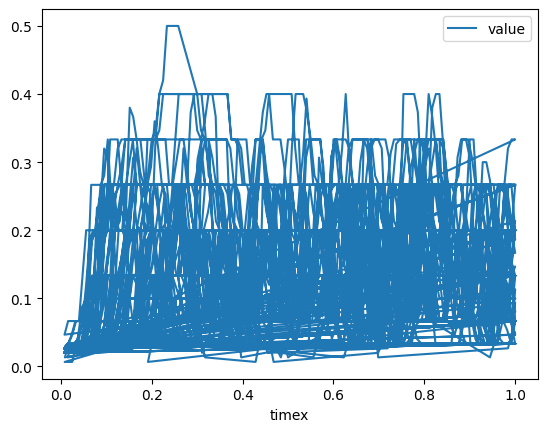

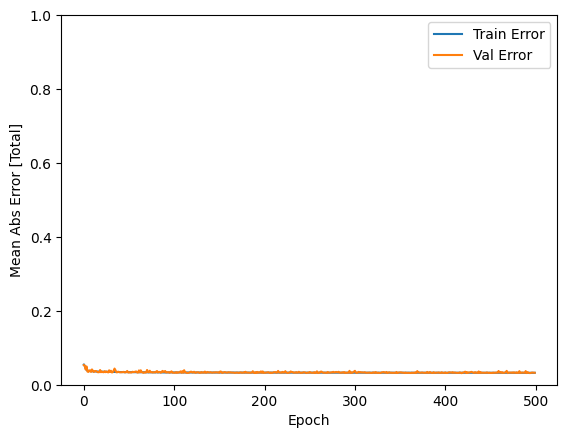

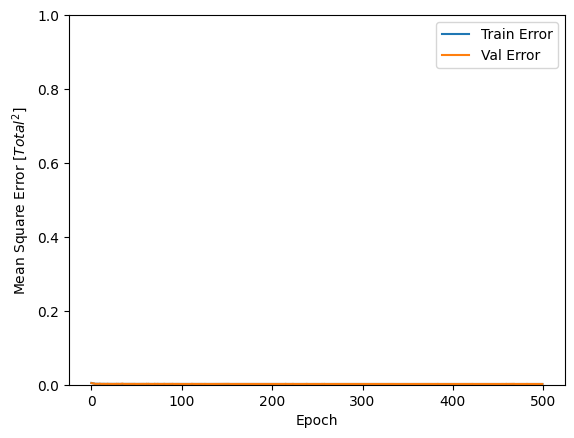

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



..............

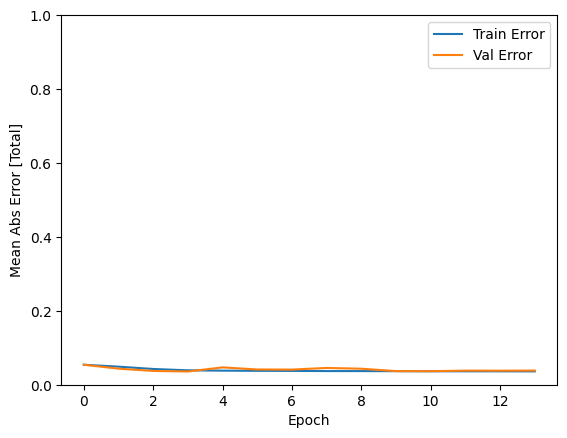

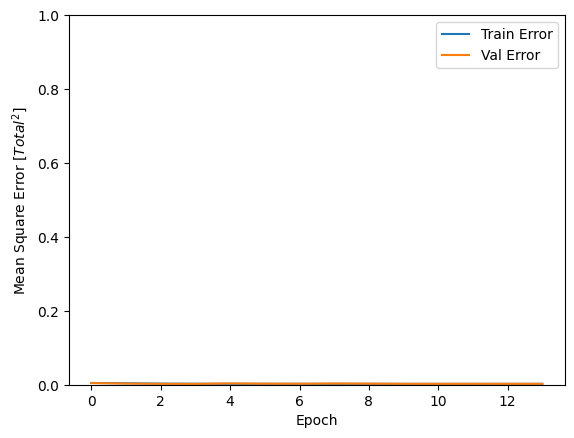

   timex  avg
0   0.01  0.9
1   0.02  0.9
2   0.03  0.9
3   0.04  0.9
4   0.05  0.9
4/4 [==============================] - 0s 1ms/step
[0.05897824 0.06952289 0.08187784 0.09447912 0.10734648 0.12021386
 0.13308126 0.14594859 0.1588614  0.17172194 0.1845997  0.19731489
 0.20983219 0.22198403 0.23260349 0.23981047 0.24312934 0.24342033
 0.24360198 0.24351874 0.24320066 0.24237779 0.24155486 0.24073204
 0.23983252 0.23809898 0.23569578 0.23329258 0.23088938 0.22871298
 0.2265591  0.2244052  0.22223979 0.22003868 0.21783799 0.21586275
 0.2140213  0.21217981 0.2103383  0.20849684 0.20675367 0.20641866
 0.20615909 0.20602748 0.20620748 0.20638749 0.2070182  0.20764515
 0.20827213 0.20889908 0.209526   0.21015552 0.2107917  0.2114253
 0.21204159 0.21265912 0.21327671 0.21389422 0.21449715 0.21504053
 0.21558392 0.21612522 0.21666408 0.21720305 0.21775305 0.21834314
 0.21893355 0.21952397 0.22011432 0.22092155 0.22180751 0.22268933
 0.22357109 0.22445282 0.22533569 0.2262193  0.22698948 0.2275

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

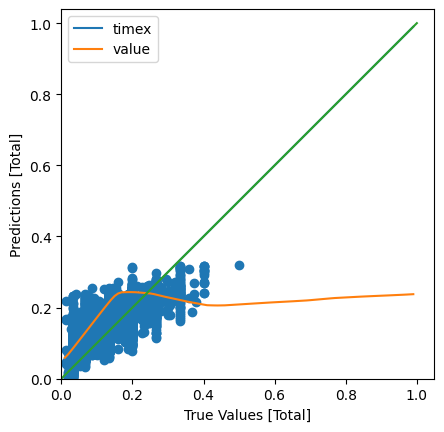

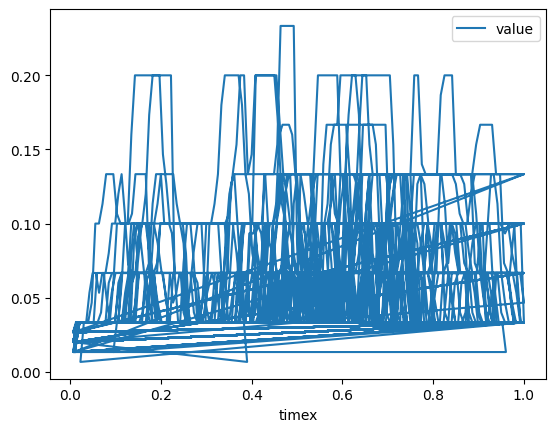

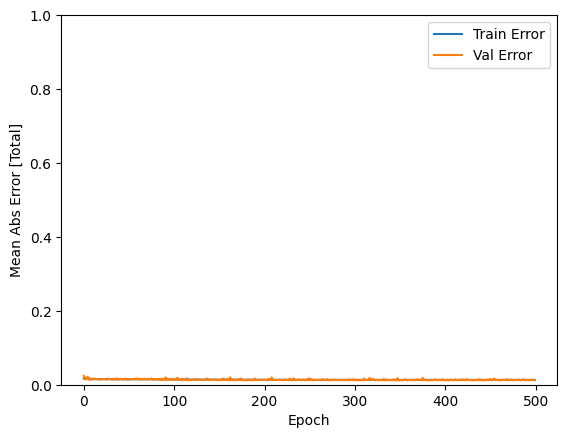

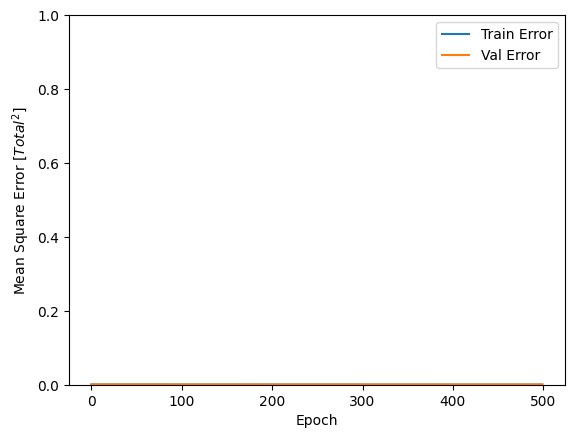

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



...............

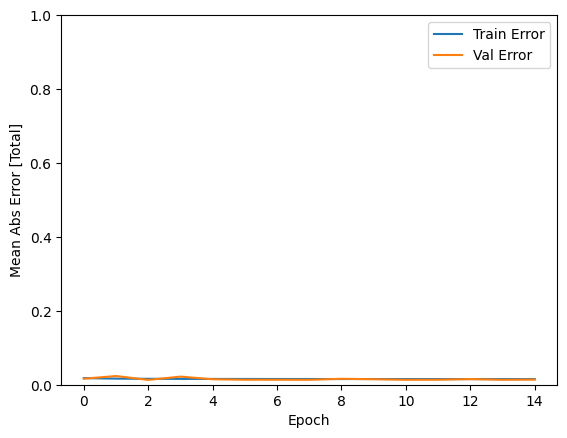

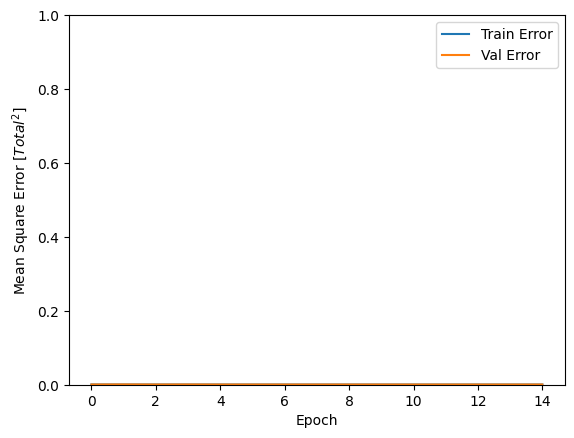

   timex  avg
0   0.01  0.9
1   0.02  0.9
2   0.03  0.9
3   0.04  0.9
4   0.05  0.9
4/4 [==============================] - 0s 1ms/step
[0.0264712  0.02831096 0.02984232 0.0308408  0.03175665 0.03267251
 0.03358833 0.03458354 0.0356337  0.03668387 0.03770807 0.03865638
 0.03960468 0.04046796 0.04083904 0.04119445 0.040983   0.0406611
 0.04030274 0.03994439 0.03959859 0.03928256 0.03896652 0.03875283
 0.03856606 0.03837928 0.03816942 0.03796118 0.03776711 0.03794586
 0.03814564 0.03844665 0.03880034 0.03915983 0.03951932 0.03991982
 0.04058059 0.04135625 0.04213989 0.04300692 0.04387477 0.04471385
 0.04537782 0.04604363 0.04670944 0.04734341 0.04797243 0.04860142
 0.04923043 0.04985651 0.05031938 0.05005155 0.0499338  0.04988512
 0.04983975 0.04979436 0.049749   0.04970363 0.04965826 0.04961288
 0.04956749 0.04951835 0.0494646  0.04941085 0.04935711 0.04930335
 0.04924959 0.04916991 0.04906011 0.04890324 0.04874637 0.04852864
 0.04820678 0.04788494 0.04743394 0.04690135 0.04624173 0.0455

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

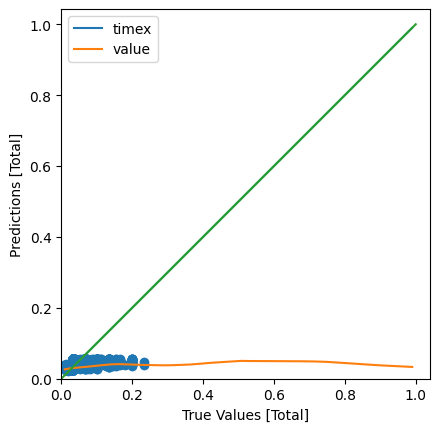

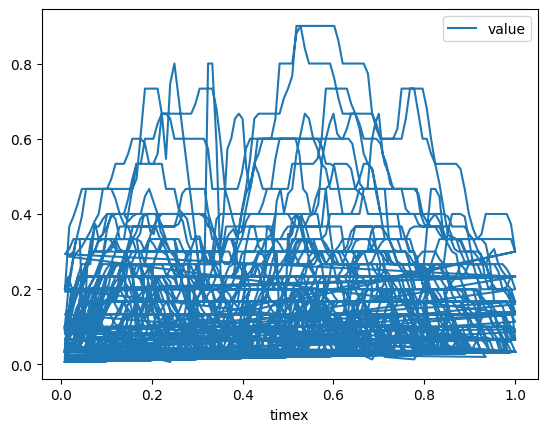

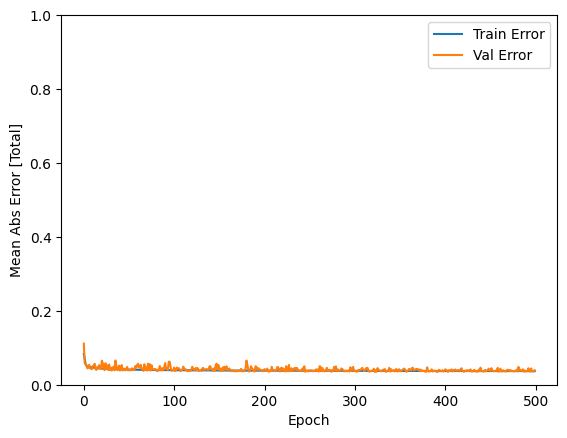

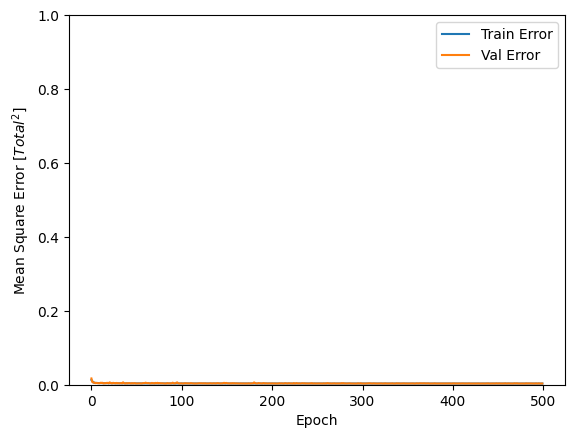

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



......................

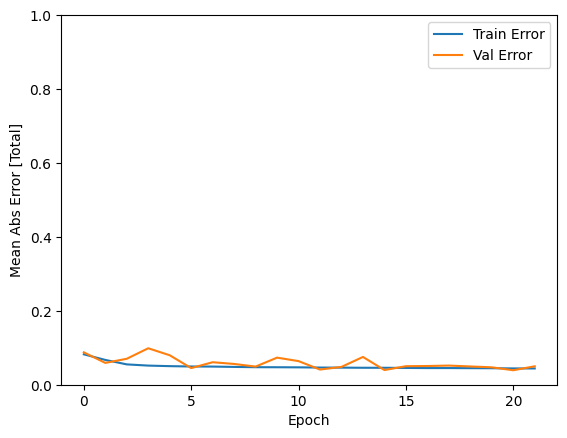

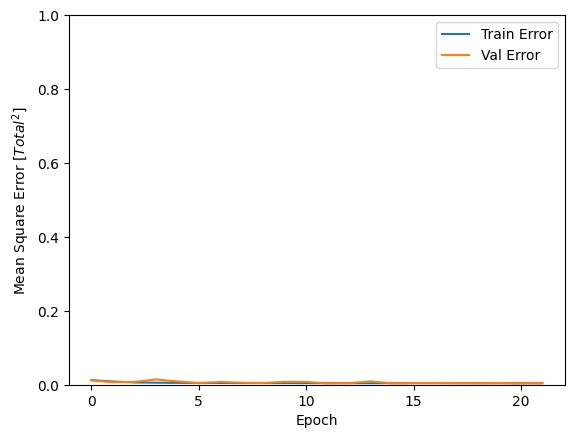

   timex  avg
0   0.01  0.9
1   0.02  0.9
2   0.03  0.9
3   0.04  0.9
4   0.05  0.9
4/4 [==============================] - 0s 1ms/step
[0.05784821 0.07096256 0.08407703 0.0971914  0.11030576 0.12342016
 0.13653447 0.14964886 0.16276327 0.17569937 0.18426824 0.18789105
 0.18872398 0.18744487 0.18506476 0.18268451 0.18030429 0.1779241
 0.175544   0.17328487 0.1711172  0.16902664 0.16693422 0.16484132
 0.16274847 0.16082028 0.15941665 0.15801299 0.15660943 0.15520577
 0.15380219 0.15239859 0.1510183  0.15139428 0.15246493 0.15354963
 0.1546341  0.15596616 0.15743704 0.15890785 0.16080889 0.16322951
 0.16565004 0.16807052 0.17049119 0.17291173 0.17525628 0.17755201
 0.17955583 0.1814341  0.1833036  0.1851383  0.18697302 0.18880787
 0.19064264 0.19130936 0.18940666 0.18746972 0.18553272 0.18359578
 0.1816584  0.179721   0.17778349 0.175846   0.17390844 0.171971
 0.1700335  0.16771418 0.16387534 0.16002114 0.1560747  0.15113604
 0.14619744 0.14125884 0.13632026 0.13138163 0.12644294 0.121504

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

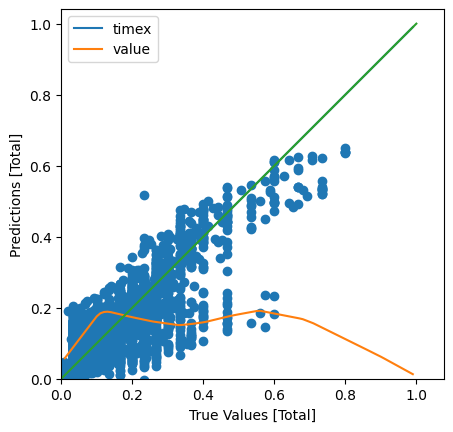

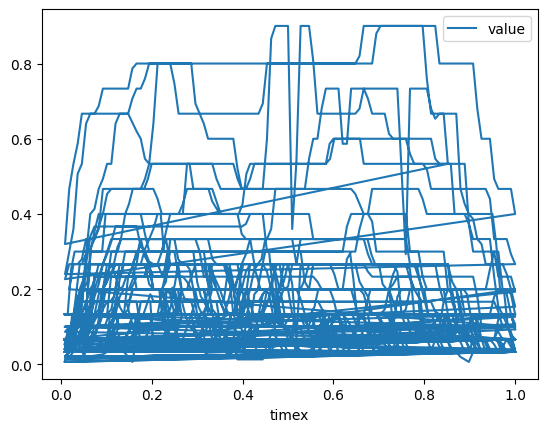

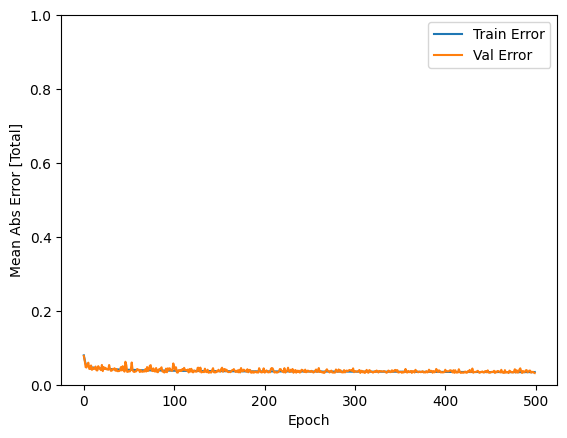

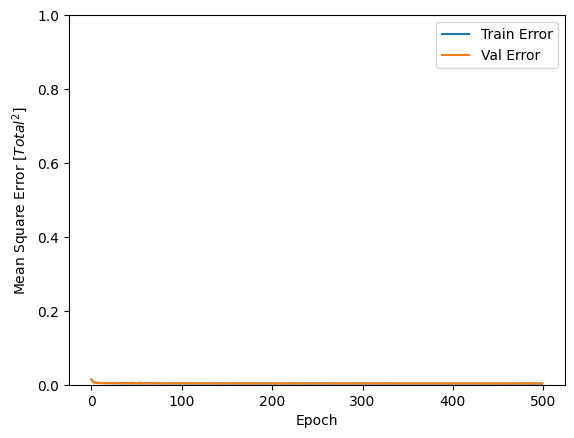

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................

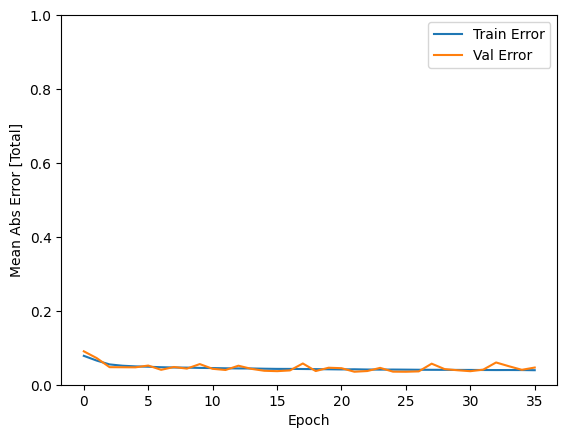

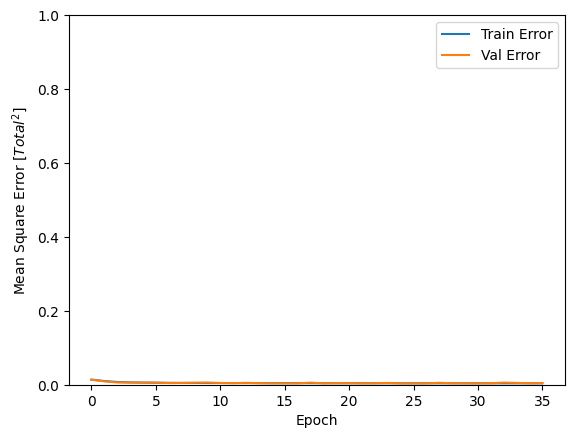

   timex  avg
0   0.01  0.9
1   0.02  0.9
2   0.03  0.9
3   0.04  0.9
4   0.05  0.9
4/4 [==============================] - 0s 1ms/step
[0.15268572 0.16771664 0.18274021 0.19776379 0.21278733 0.22781092
 0.24283448 0.25782287 0.27124134 0.28227806 0.292797   0.30329108
 0.31076923 0.3146851  0.31714848 0.31948507 0.32177016 0.32283044
 0.32321796 0.32344446 0.32341412 0.3233837  0.3233533  0.3218977
 0.32014793 0.31839812 0.3166483  0.31489852 0.31314877 0.31139895
 0.30964923 0.30789936 0.3061496  0.30439976 0.3027935  0.30125442
 0.29981434 0.2983895  0.29696456 0.2955397  0.2941149  0.29268992
 0.29126507 0.2898402  0.28841534 0.28699037 0.28565958 0.28504798
 0.2844363  0.28382465 0.283213   0.28260133 0.28198966 0.2813781
 0.28076646 0.28015473 0.2795431  0.2789315  0.2783198  0.2777081
 0.27709648 0.27648485 0.27587318 0.27495578 0.27264208 0.2703283
 0.26801458 0.2657008  0.263387   0.26107326 0.25875956 0.2564458
 0.25413203 0.25181827 0.24950454 0.24712622 0.24397397 0.24058501

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

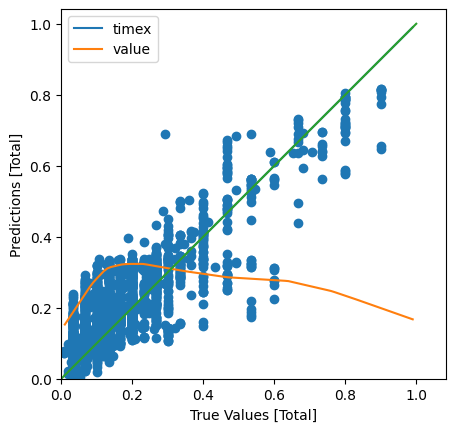

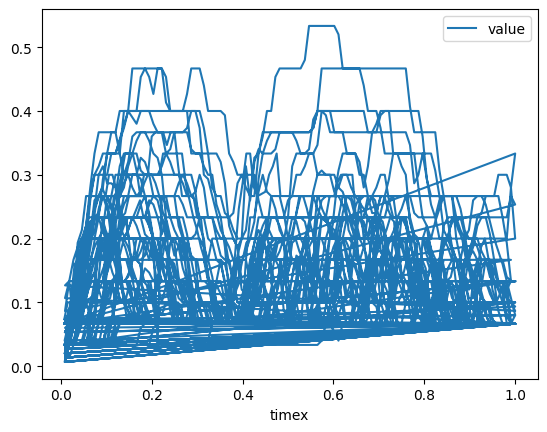

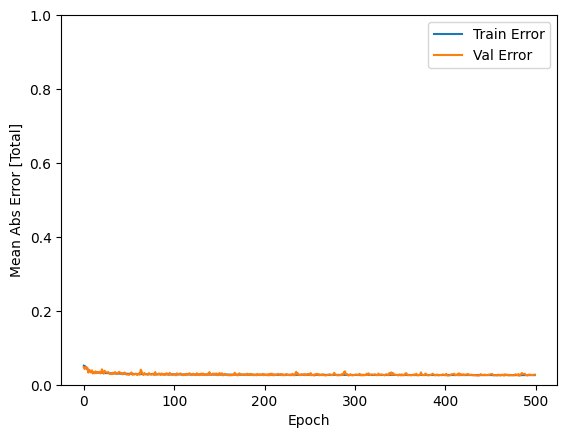

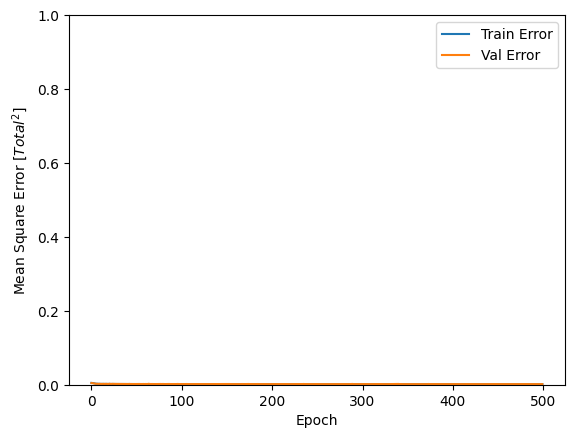

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



..........................................

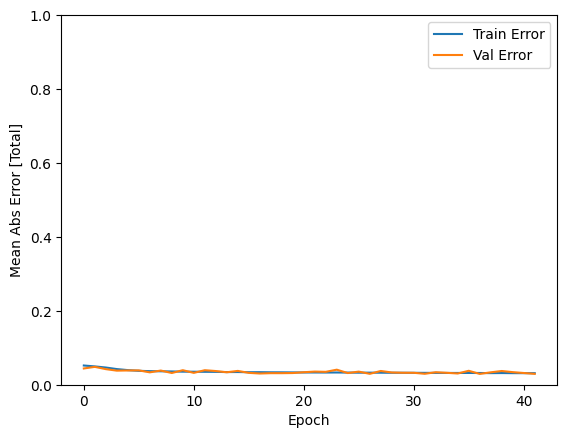

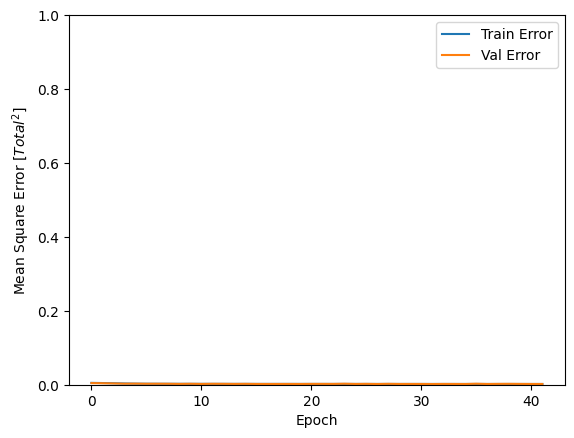

   timex  avg
0   0.01  0.9
1   0.02  0.9
2   0.03  0.9
3   0.04  0.9
4   0.05  0.9
4/4 [==============================] - 0s 843us/step
[0.02108895 0.03549265 0.05158512 0.06767766 0.08377016 0.09986266
 0.11597229 0.13219321 0.14874235 0.1657091  0.18267591 0.19696818
 0.20663163 0.20979212 0.20601082 0.20121798 0.19632418 0.19143039
 0.18653658 0.18164283 0.17652991 0.17134131 0.16445479 0.15757498
 0.15069519 0.14381543 0.13693564 0.13002518 0.12310786 0.11619052
 0.10932848 0.10262753 0.09594236 0.08925912 0.08604716 0.08473016
 0.0834724  0.08630183 0.08957775 0.09374674 0.09791571 0.1020847
 0.10625372 0.11042121 0.1145824  0.1187436  0.12290479 0.12706597
 0.1312272  0.13538837 0.13954958 0.14364879 0.14756943 0.15124226
 0.15465084 0.15760948 0.16056818 0.16352688 0.16648561 0.16944432
 0.1721645  0.1737853  0.1747868  0.17477274 0.17475857 0.17401345
 0.17277749 0.1715059  0.16837096 0.16479215 0.1611768  0.15756151
 0.15392342 0.15026303 0.1466026  0.14294216 0.13928176 0.13

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

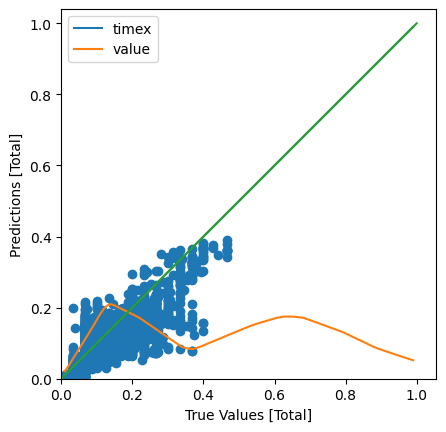

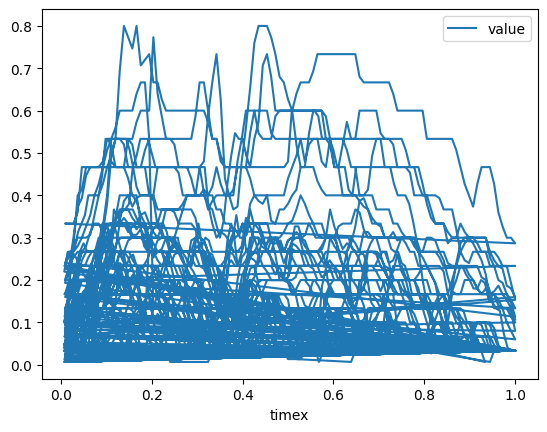

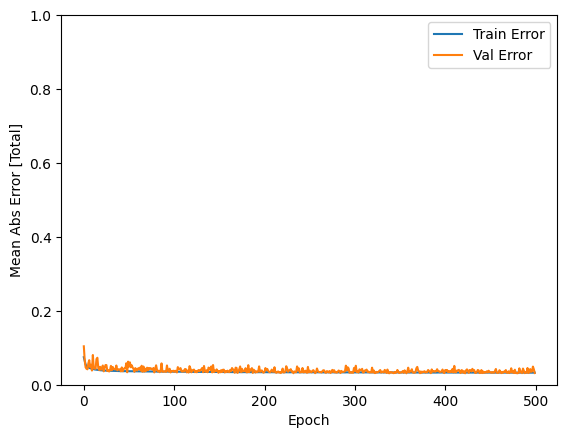

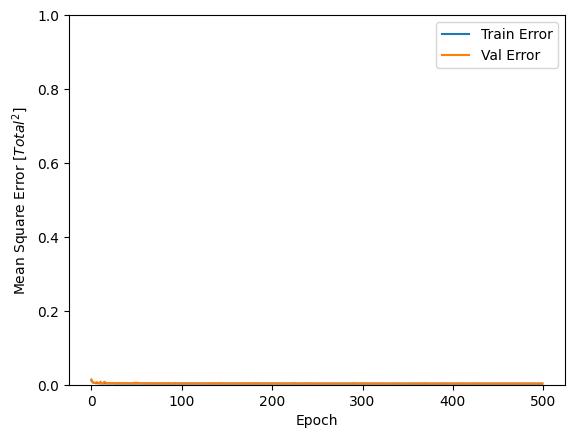

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



.........................................

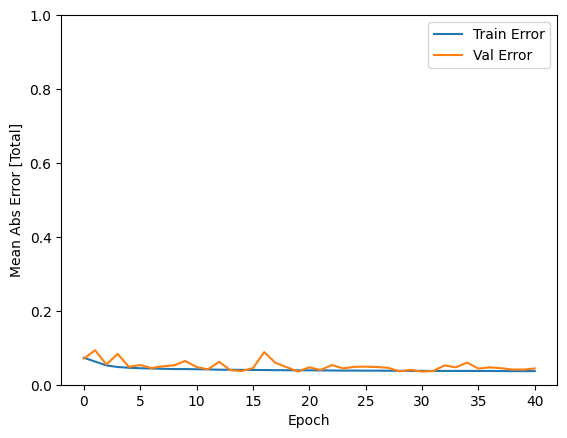

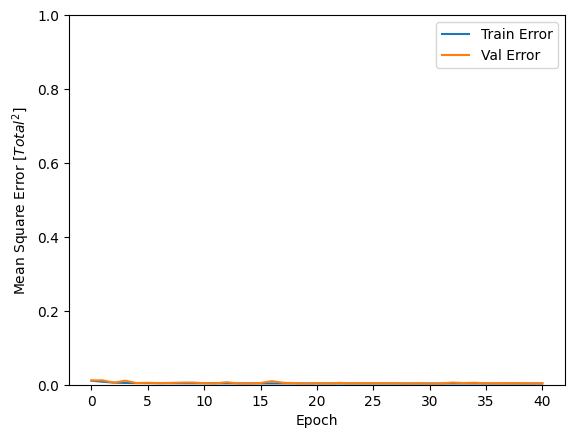

   timex  avg
0   0.01  0.9
1   0.02  0.9
2   0.03  0.9
3   0.04  0.9
4   0.05  0.9
4/4 [==============================] - 0s 1ms/step
[0.12260538 0.13399892 0.14539242 0.15678596 0.16817945 0.17957297
 0.19096646 0.20195007 0.21251318 0.2230763  0.23363942 0.24394462
 0.24738994 0.24818021 0.24848005 0.24499372 0.24142796 0.23770344
 0.23391518 0.23008844 0.22627172 0.22199327 0.21763793 0.2131207
 0.20722318 0.20131293 0.19540739 0.1895023  0.18359733 0.17769226
 0.17179677 0.16657777 0.16321698 0.16171531 0.16021371 0.16057862
 0.16123144 0.16188419 0.16253698 0.16318981 0.16384262 0.16449535
 0.16514814 0.16580093 0.16645372 0.16710651 0.16775927 0.16841207
 0.16906486 0.16971767 0.17037046 0.17102319 0.17089793 0.16999713
 0.16909173 0.16763613 0.16617347 0.16471079 0.16324812 0.16178547
 0.15987901 0.15793042 0.15600252 0.15428555 0.15256858 0.15085164
 0.14913465 0.14613275 0.14310095 0.14006916 0.13703738 0.13400555
 0.13076007 0.12667428 0.12243809 0.11813898 0.11383982 0.1095

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

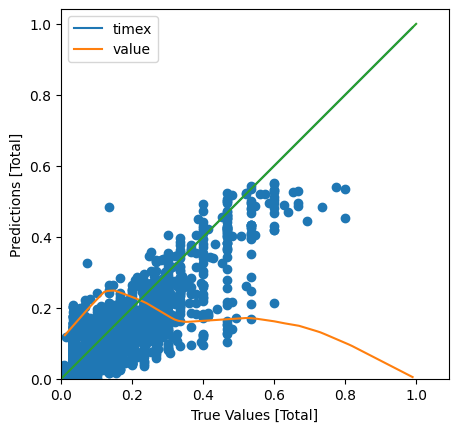

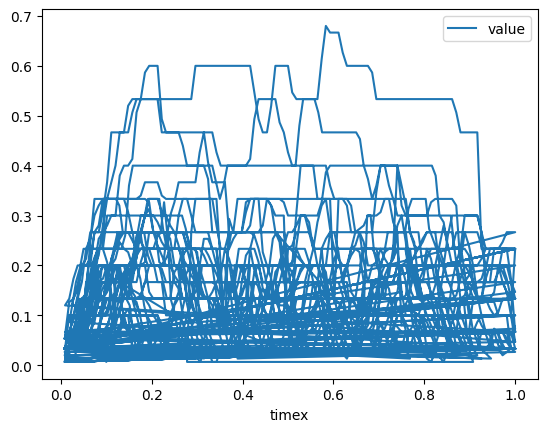

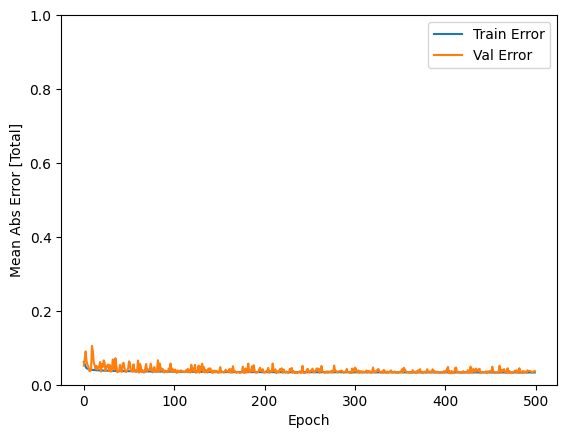

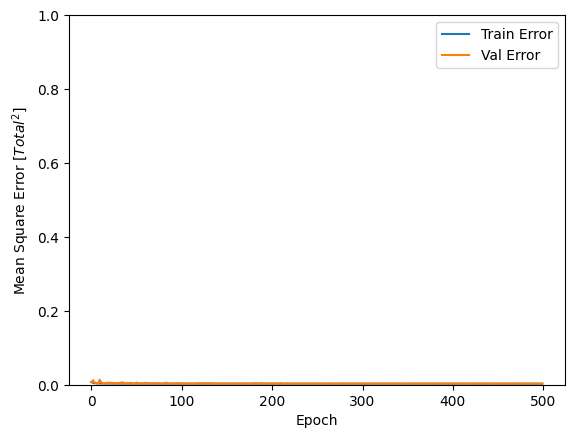

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



............................................

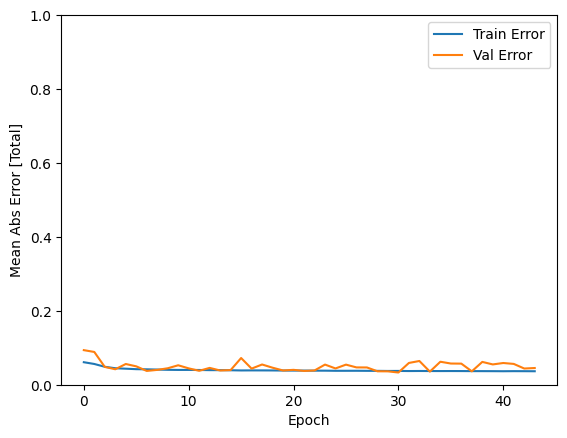

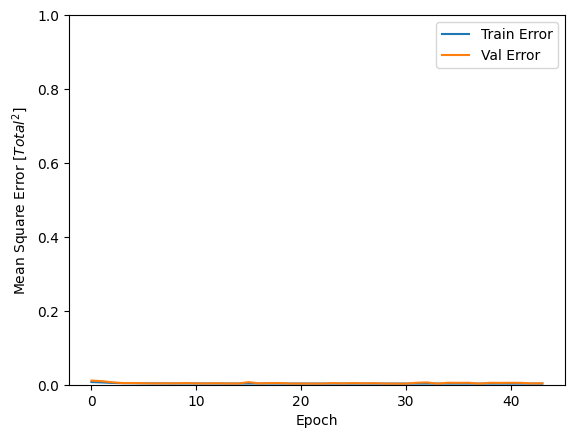

   timex  avg
0   0.01  0.9
1   0.02  0.9
2   0.03  0.9
3   0.04  0.9
4   0.05  0.9
4/4 [==============================] - 0s 957us/step
[0.15749323 0.1720373  0.18658125 0.2011252  0.21499807 0.22424096
 0.23348385 0.23942196 0.24090965 0.24146545 0.24055248 0.23963952
 0.23872654 0.23719376 0.23389821 0.23060268 0.22731674 0.22403306
 0.22074941 0.21746573 0.21418078 0.21237428 0.21135822 0.21030782
 0.20923601 0.20816417 0.20709237 0.20602053 0.20494878 0.20387696
 0.20234695 0.20033285 0.19799165 0.1923097  0.18668044 0.18410008
 0.18288356 0.18173254 0.18121538 0.18087286 0.18121521 0.18152386
 0.18183248 0.18192405 0.18199275 0.18206146 0.18213019 0.18218738
 0.18228348 0.1824077  0.1822614  0.18192522 0.18158907 0.1812529
 0.18091673 0.18058059 0.18024439 0.17990822 0.17957206 0.17923588
 0.1788997  0.17856355 0.1782274  0.17789122 0.17755504 0.17721887
 0.17688268 0.17654653 0.17621037 0.1758742  0.17481658 0.17362604
 0.17233269 0.17053542 0.16859944 0.16648133 0.1643598  0.16

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

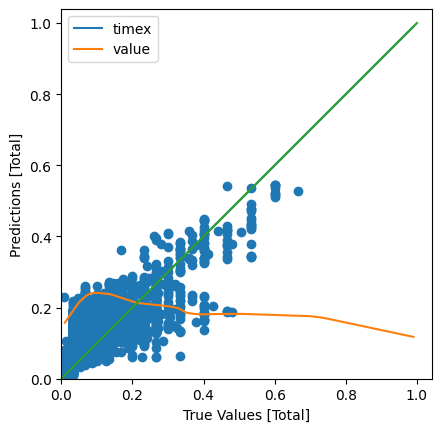

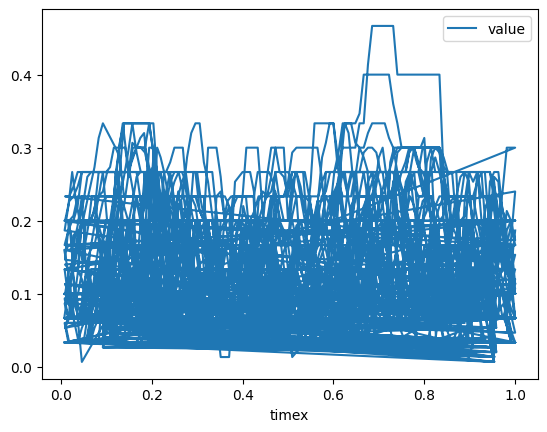

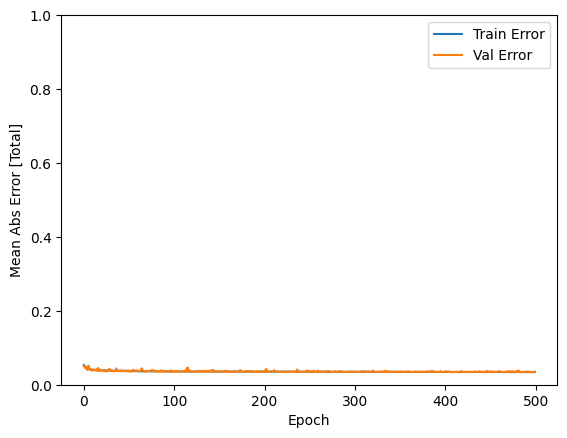

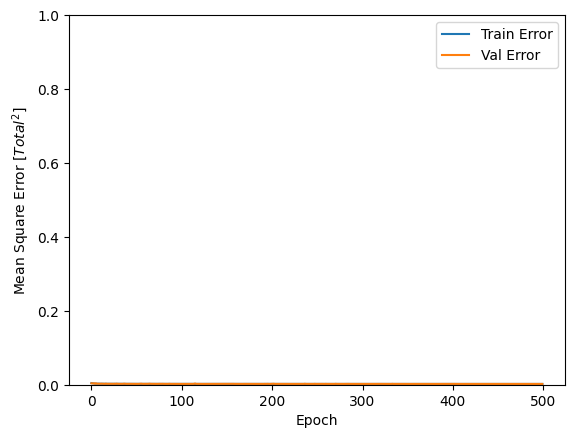

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



..............................................

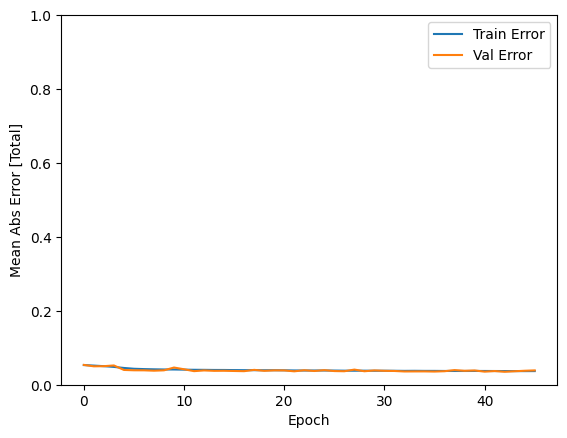

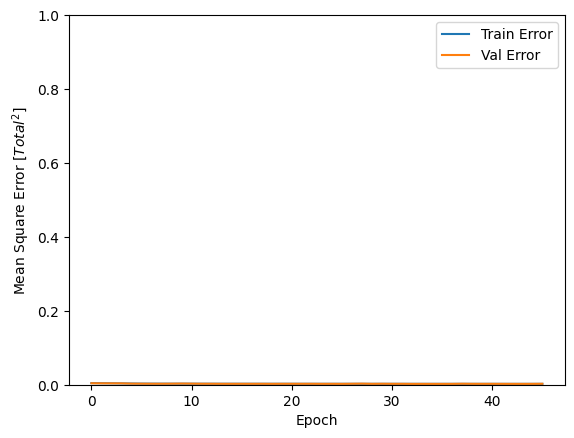

   timex  avg
0   0.01  0.9
1   0.02  0.9
2   0.03  0.9
3   0.04  0.9
4   0.05  0.9
4/4 [==============================] - 0s 2ms/step
[0.20217454 0.20719817 0.2122183  0.21723834 0.22225848 0.22727858
 0.2322987  0.23720433 0.24200064 0.24679698 0.2515892  0.25633466
 0.26019666 0.26216963 0.2564839  0.25079814 0.24511239 0.2394266
 0.2337409  0.22805512 0.22236936 0.21666932 0.21092795 0.20516248
 0.19929132 0.19342017 0.18754901 0.18167788 0.17580672 0.16993558
 0.16406447 0.15819332 0.15232217 0.146451   0.14202371 0.13987327
 0.13894905 0.1394836  0.1400182  0.14055282 0.14108738 0.141626
 0.14247873 0.14475392 0.14742981 0.15010582 0.15278181 0.1559362
 0.15934582 0.16275546 0.16616508 0.16957474 0.17298436 0.17627594
 0.17943847 0.18235798 0.18488851 0.18741906 0.18994954 0.19242723
 0.19474444 0.19703119 0.19920766 0.20138417 0.20356065 0.20572203
 0.20718302 0.2072716  0.20708536 0.20675704 0.20642868 0.2061004
 0.20577201 0.20544368 0.20454006 0.20360245 0.20266482 0.20172724

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

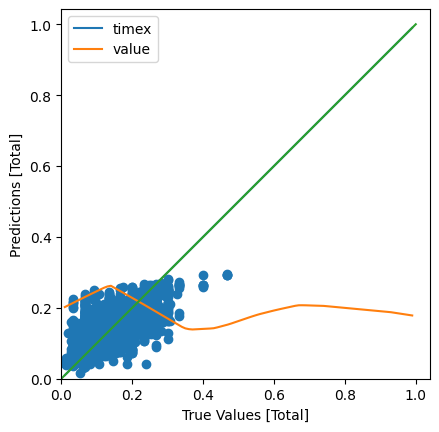

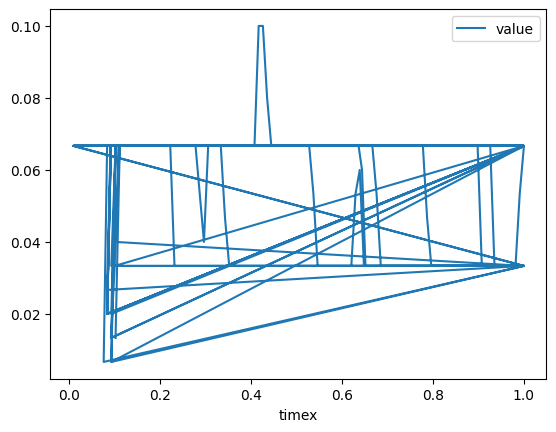

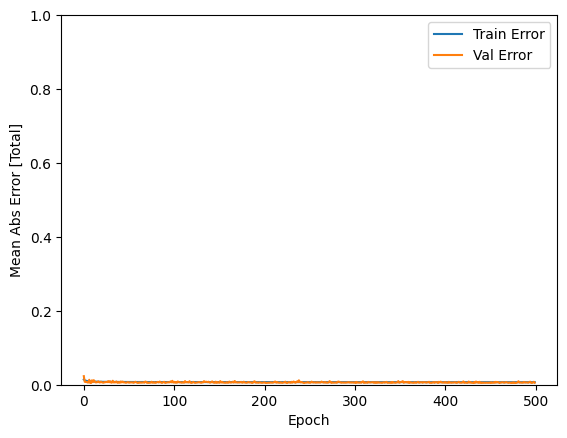

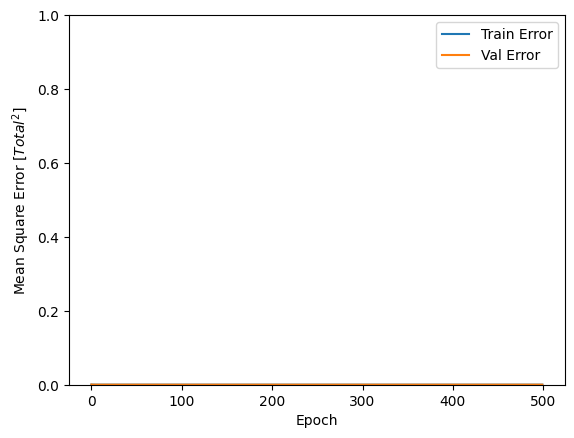

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



...............

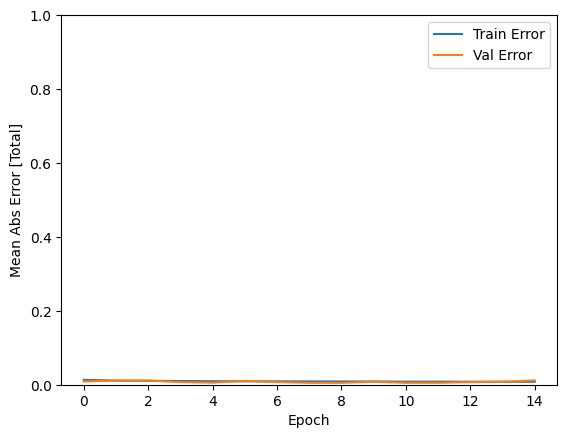

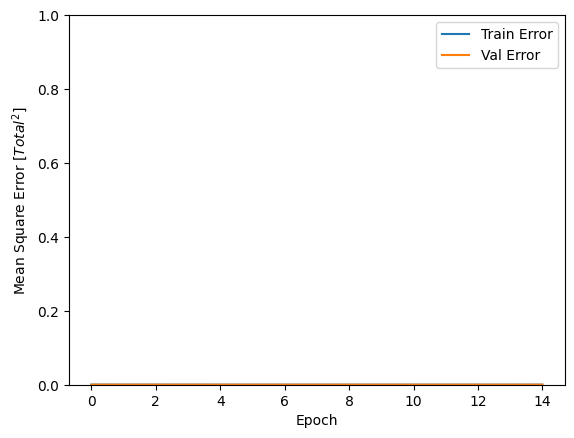

   timex  avg
0   0.01  0.9
1   0.02  0.9
2   0.03  0.9
3   0.04  0.9
4   0.05  0.9
4/4 [==============================] - 0s 3ms/step
[0.05960452 0.05984499 0.0599975  0.05989667 0.0597958  0.05969497
 0.05959412 0.05949327 0.05939244 0.05946825 0.05968011 0.05998838
 0.06042817 0.06086799 0.06120396 0.06125431 0.06140613 0.06150834
 0.06161059 0.06171282 0.06181505 0.06191728 0.06201951 0.06212174
 0.06222397 0.06249595 0.06275666 0.06284118 0.06292574 0.06295643
 0.06284193 0.06272744 0.06261294 0.06249845 0.06238394 0.06226945
 0.06222039 0.06219235 0.06216432 0.06213626 0.06205025 0.06187946
 0.06179979 0.06176426 0.06172874 0.06178387 0.06189543 0.06200834
 0.06212122 0.06229362 0.06237908 0.06246263 0.06254619 0.06262972
 0.06271324 0.06278531 0.06285431 0.06292335 0.06299236 0.06306137
 0.0631304  0.06319942 0.06326843 0.06333744 0.06332078 0.06312509
 0.06286951 0.06261396 0.0623584  0.06210282 0.06188276 0.06172792
 0.06157308 0.06141822 0.0610605  0.06061946 0.06060845 0.060

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

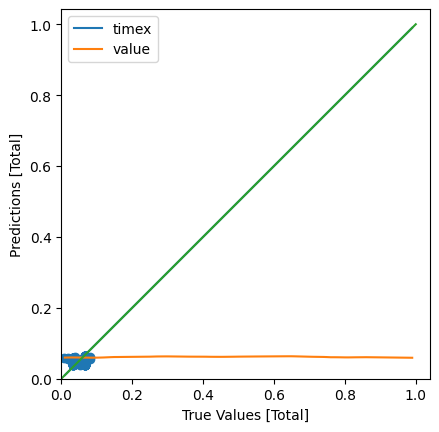

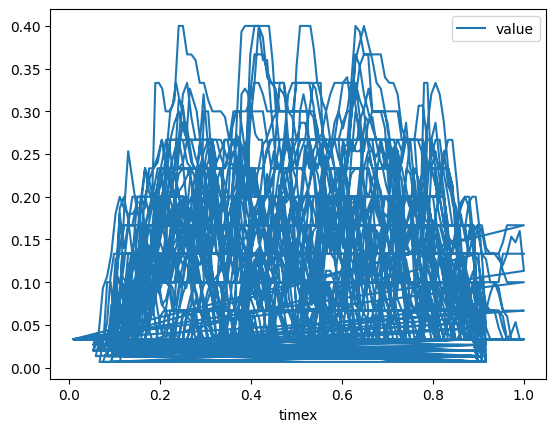

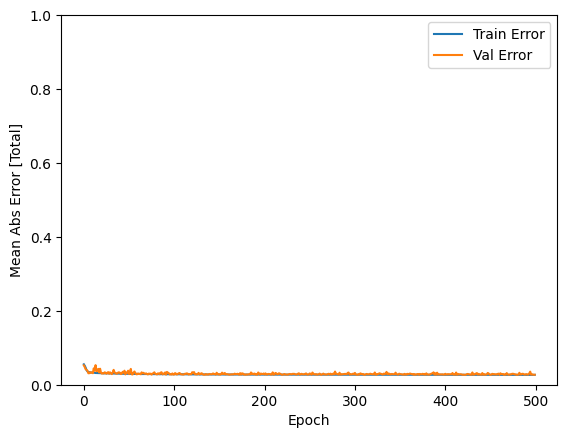

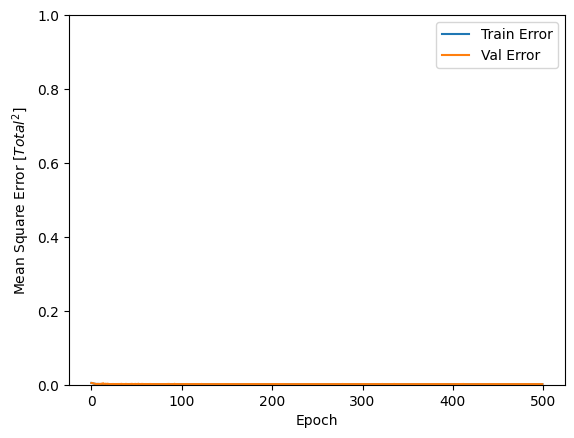

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



............................

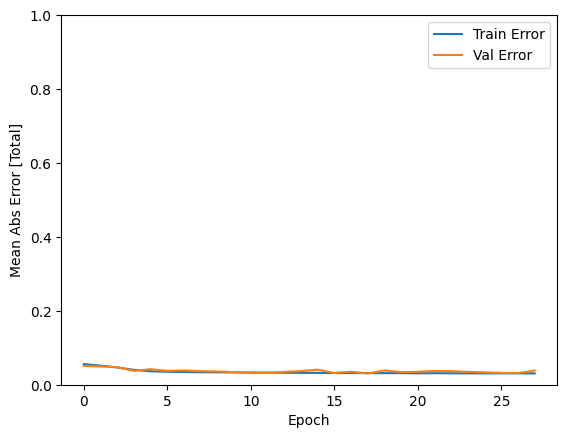

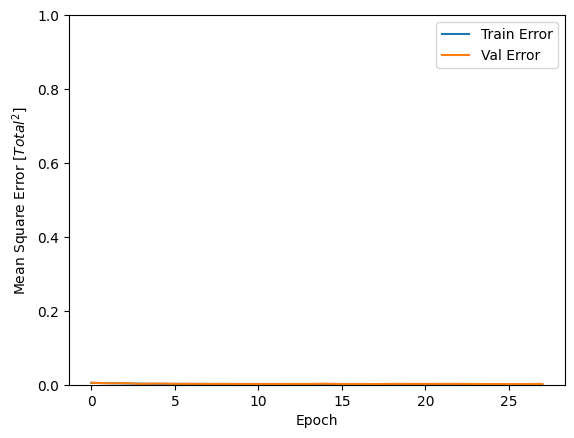

   timex  avg
0   0.01  0.9
1   0.02  0.9
2   0.03  0.9
3   0.04  0.9
4   0.05  0.9
4/4 [==============================] - 0s 7ms/step
[0.03249391 0.03836476 0.04423562 0.05010652 0.05673596 0.06441329
 0.07218325 0.08021048 0.08934647 0.0992754  0.10920437 0.11913329
 0.12923416 0.13862804 0.14777848 0.15617615 0.16381054 0.17144495
 0.17907938 0.18671378 0.19244677 0.19596033 0.19933474 0.20033327
 0.20086181 0.20116392 0.20146602 0.2017681  0.2020702  0.2023723
 0.20267439 0.20302305 0.20337382 0.20372453 0.20407528 0.20442727
 0.20478213 0.20513698 0.20549184 0.2058467  0.20620158 0.20655641
 0.2069113  0.20726612 0.20762098 0.20760995 0.20725155 0.20651802
 0.20578286 0.20504773 0.20431256 0.20357737 0.20284224 0.20145196
 0.19962746 0.19780293 0.19597846 0.19415021 0.19228458 0.19040361
 0.18851641 0.18662915 0.18474185 0.18285462 0.18096738 0.17886224
 0.1766116  0.17436096 0.17211029 0.16985962 0.16760498 0.16531473
 0.16302454 0.1607343  0.15844405 0.15549582 0.15253437 0.1489

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

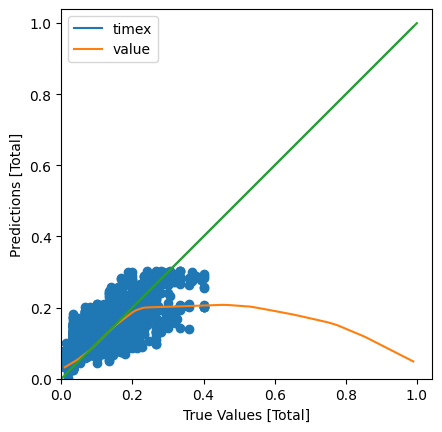

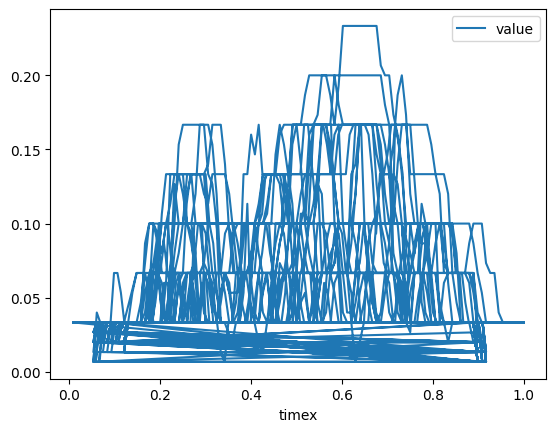

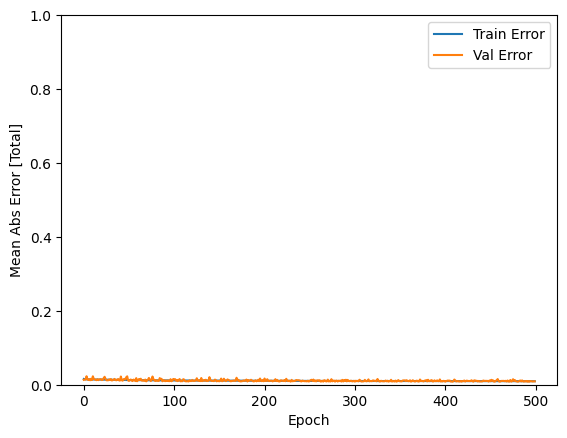

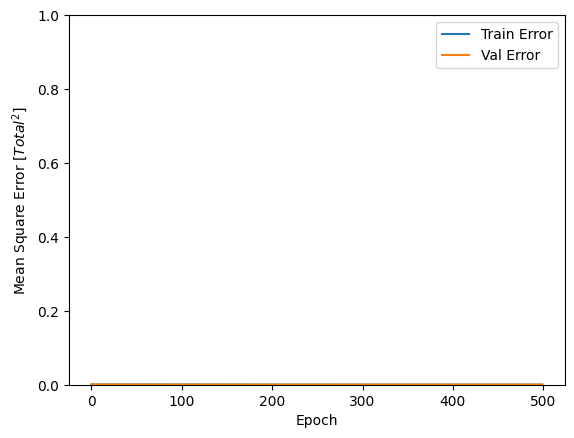

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................................................
...........

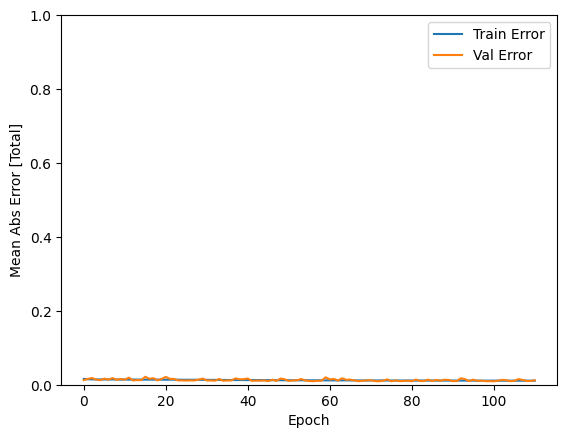

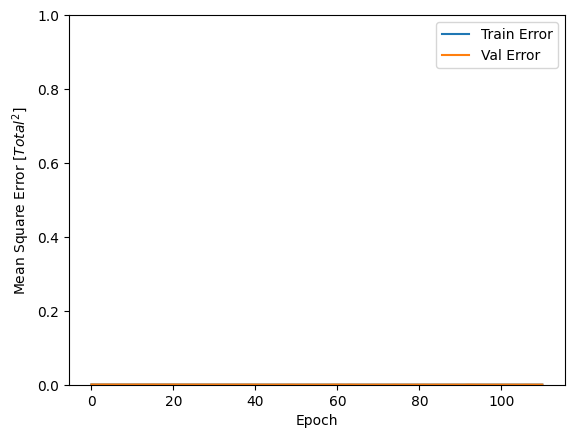

   timex  avg
0   0.01  0.9
1   0.02  0.9
2   0.03  0.9
3   0.04  0.9
4   0.05  0.9
4/4 [==============================] - 0s 981us/step
[0.02152616 0.02270075 0.02371669 0.02469291 0.02566541 0.02663793
 0.02761045 0.02858296 0.02955548 0.03052799 0.03150051 0.03247694
 0.03351826 0.03455957 0.03560089 0.03664219 0.03768352 0.03872484
 0.03976615 0.04080748 0.04184878 0.04289009 0.04393142 0.04470111
 0.04483664 0.04485625 0.04437017 0.04388409 0.04339217 0.04282302
 0.04225384 0.0416847  0.04111554 0.04054639 0.03997725 0.03986188
 0.04113755 0.04241325 0.04368893 0.04496463 0.04624031 0.047516
 0.04879168 0.05006515 0.05144478 0.05289615 0.05434752 0.0557989
 0.05687286 0.05741023 0.05794759 0.05850508 0.05906875 0.05963243
 0.0601961  0.06075978 0.06132345 0.06188713 0.0624508  0.06303136
 0.06362467 0.0642406  0.06487062 0.06502417 0.06414507 0.06307143
 0.06137824 0.05978015 0.05857892 0.05737768 0.05617644 0.05497519
 0.05377394 0.0525727  0.05137146 0.05038863 0.04929831 0.0479

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

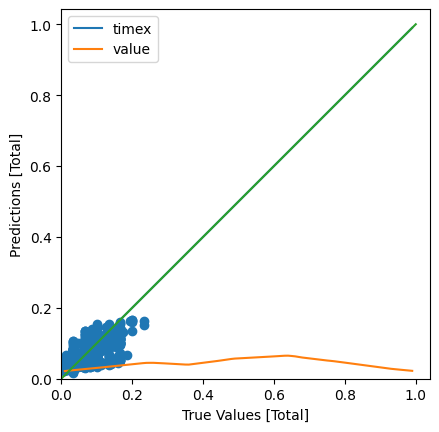

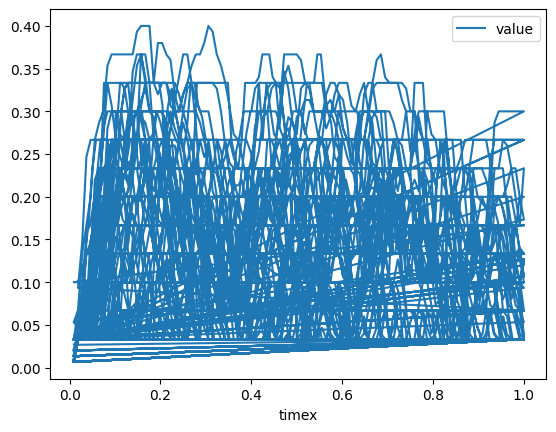

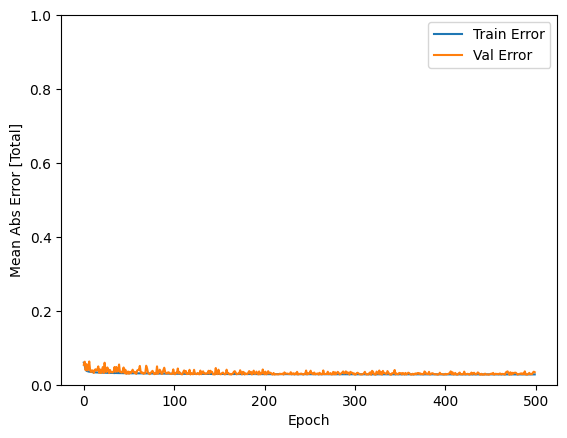

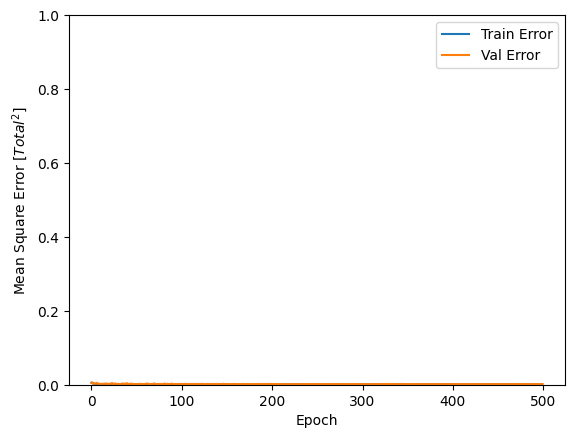

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



.........................................

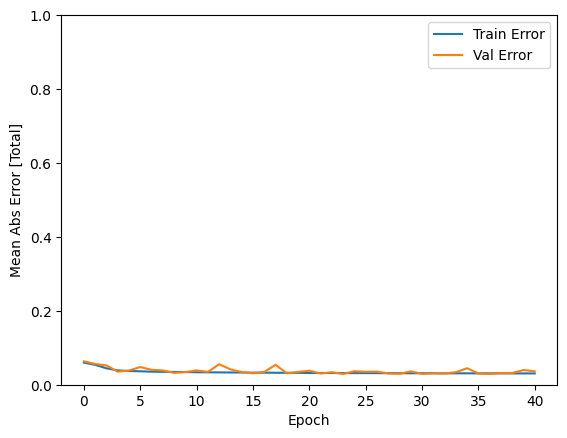

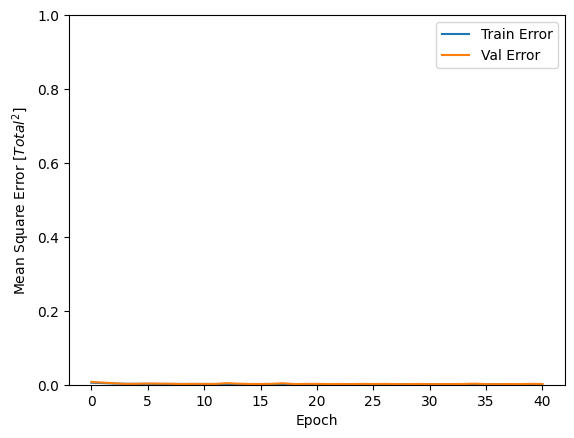

   timex  avg
0   0.01  0.9
1   0.02  0.9
2   0.03  0.9
3   0.04  0.9
4   0.05  0.9
4/4 [==============================] - 0s 1ms/step
[0.04966866 0.07008535 0.09014575 0.11020418 0.13024507 0.15028596
 0.17032689 0.19036776 0.2104087  0.23044959 0.2504905  0.2705314
 0.29040456 0.29093665 0.28953063 0.28812468 0.28593838 0.28117692
 0.27641547 0.271654   0.26601547 0.26030517 0.2545898  0.2488744
 0.24315903 0.23744367 0.23172829 0.22601289 0.22105107 0.21709596
 0.21354255 0.2101048  0.20740321 0.20470157 0.20242009 0.20155418
 0.20068826 0.19990075 0.19929925 0.2019211  0.20490101 0.20754156
 0.20958418 0.21162674 0.21366934 0.21571192 0.21775453 0.2197971
 0.22183974 0.22388232 0.22592378 0.22795928 0.22999477 0.23203033
 0.2339907  0.23361123 0.23323178 0.2328523  0.23247285 0.23209336
 0.23171392 0.23133443 0.230955   0.23057552 0.2294582  0.2281485
 0.22478054 0.22118257 0.21756996 0.21388328 0.21019664 0.20650998
 0.2028301  0.19933654 0.19584304 0.19234951 0.18885599 0.1853624

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

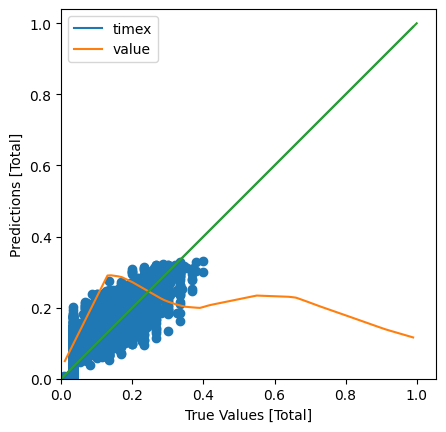

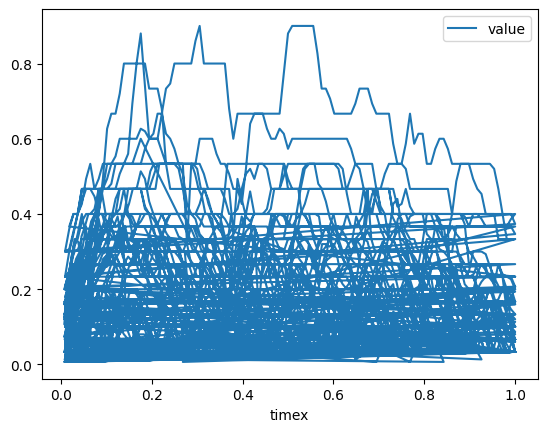

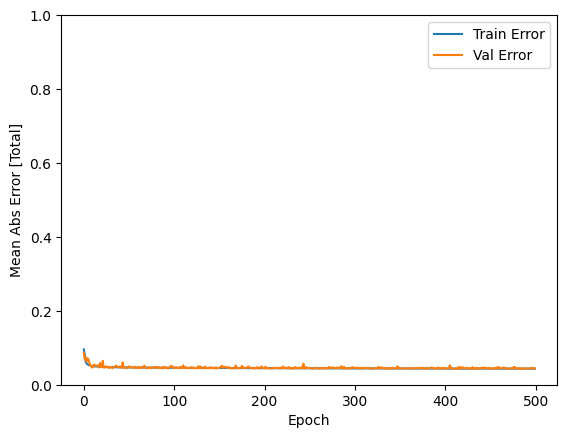

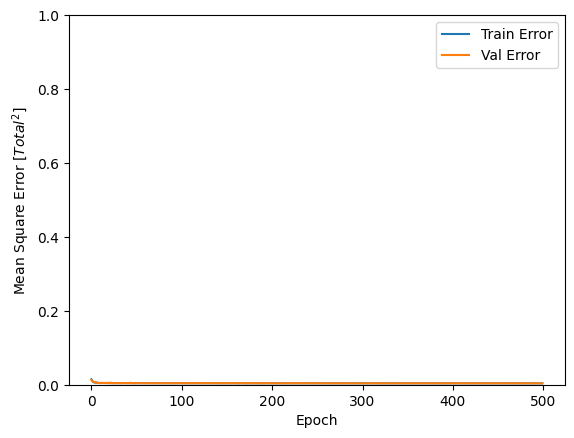

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



..............................

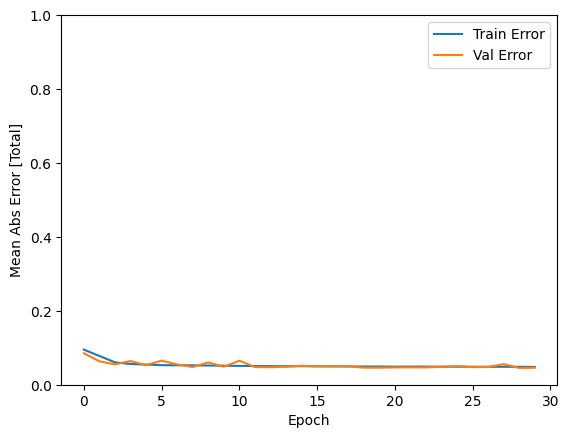

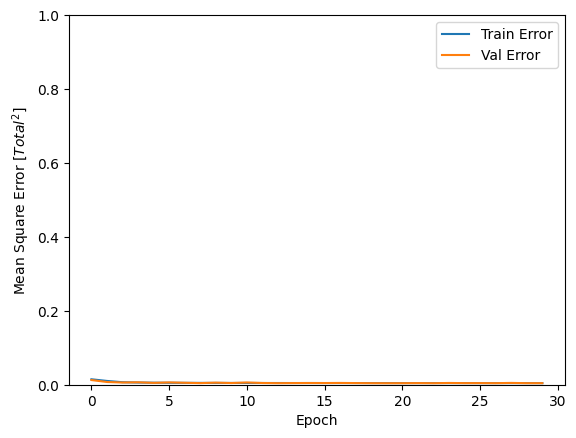

   timex  avg
0   0.01  0.9
1   0.02  0.9
2   0.03  0.9
3   0.04  0.9
4   0.05  0.9
4/4 [==============================] - 0s 1ms/step
[0.13070032 0.1537129  0.17720115 0.20092228 0.22464338 0.24836446
 0.27208644 0.29373705 0.30886972 0.32200336 0.32581055 0.3267989
 0.32700217 0.32583648 0.3220452  0.31805837 0.3139402  0.3096029
 0.30526555 0.30092824 0.29659095 0.29228336 0.28863508 0.2849868
 0.28133866 0.27769035 0.2740421  0.27039385 0.2667456  0.26309735
 0.25944906 0.25580078 0.25215253 0.2485043  0.24485604 0.2412823
 0.24117428 0.24106626 0.24095823 0.24085021 0.24074224 0.24063419
 0.24052618 0.24041815 0.24031012 0.24020208 0.24009414 0.23998605
 0.23987803 0.23977    0.23966196 0.23955391 0.23944594 0.2393379
 0.2391919  0.23901851 0.23884511 0.23867168 0.23849827 0.23832011
 0.23812889 0.23793764 0.23774631 0.23755513 0.23736385 0.23717262
 0.2369814  0.23679014 0.2365989  0.23599194 0.23409605 0.2322002
 0.23030427 0.22840846 0.22581737 0.22305933 0.22030175 0.21753119


/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

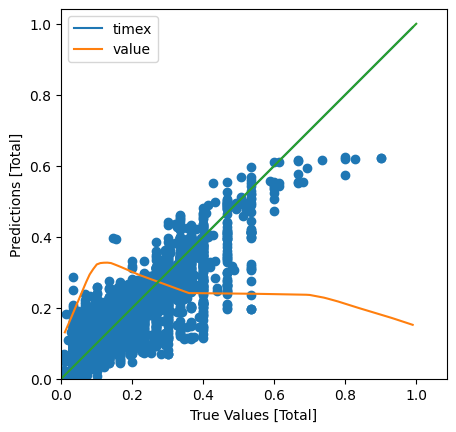

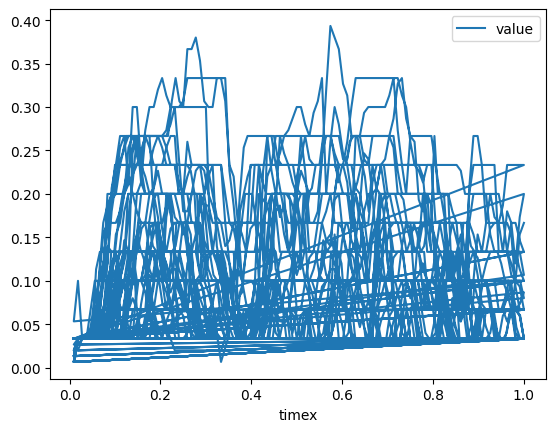

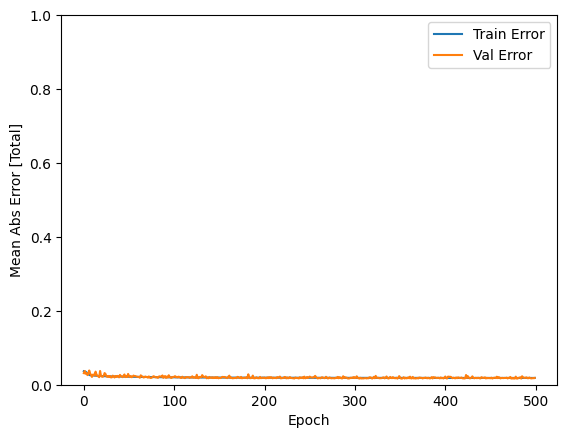

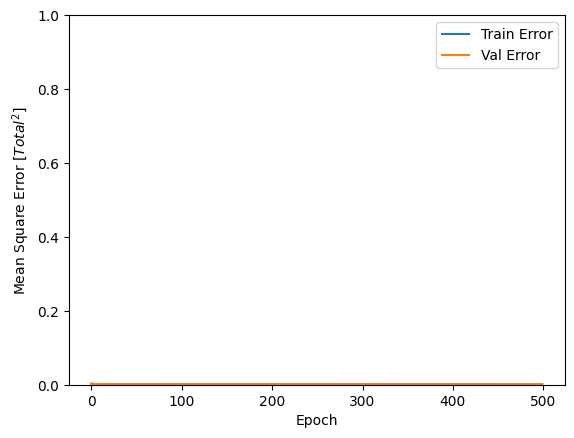

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



................................

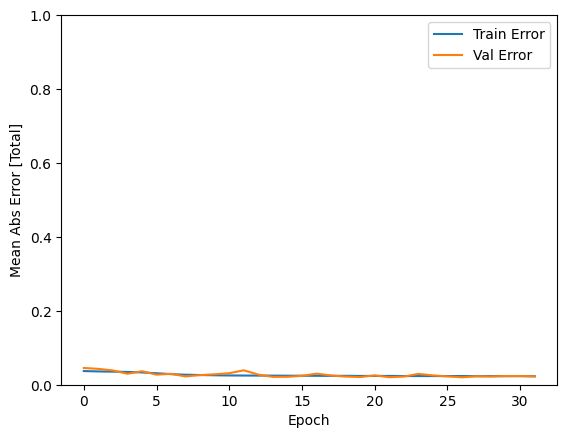

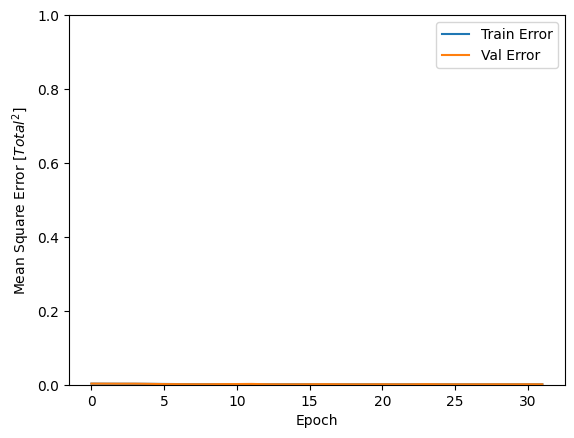

   timex  avg
0   0.01  0.9
1   0.02  0.9
2   0.03  0.9
3   0.04  0.9
4   0.05  0.9
4/4 [==============================] - 0s 912us/step
[0.02877965 0.03607359 0.04344922 0.05089067 0.05833266 0.06529634
 0.07225999 0.07922367 0.08618732 0.09315102 0.10011468 0.10707832
 0.114043   0.12103086 0.12760842 0.12987643 0.13214448 0.13441251
 0.1366806  0.13889736 0.1411145  0.1432795  0.1444886  0.14169729
 0.13809586 0.13449444 0.13028538 0.1258926  0.12149978 0.11711824
 0.11274952 0.10838087 0.10401212 0.09964342 0.09527474 0.09091406
 0.08663832 0.08472744 0.08377654 0.08494816 0.08632216 0.08769614
 0.0890701  0.0904441  0.09181809 0.09319205 0.09446248 0.09571005
 0.09695754 0.09820509 0.09945264 0.10070014 0.10194768 0.10314357
 0.10407467 0.10500576 0.1050898  0.10436311 0.10363647 0.10290981
 0.10190092 0.10048216 0.09897249 0.09746282 0.09595317 0.09444346
 0.09293212 0.0914204  0.0899087  0.08839704 0.0868853  0.08537367
 0.08386198 0.08235031 0.08083865 0.07931705 0.07771799 0.0

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

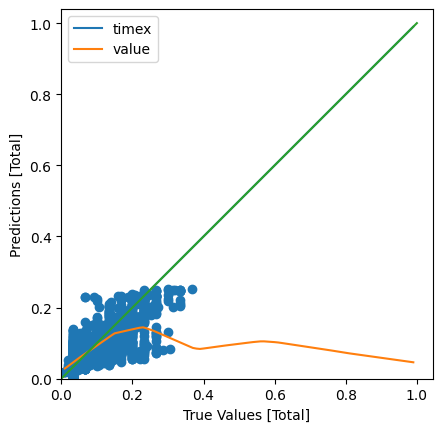

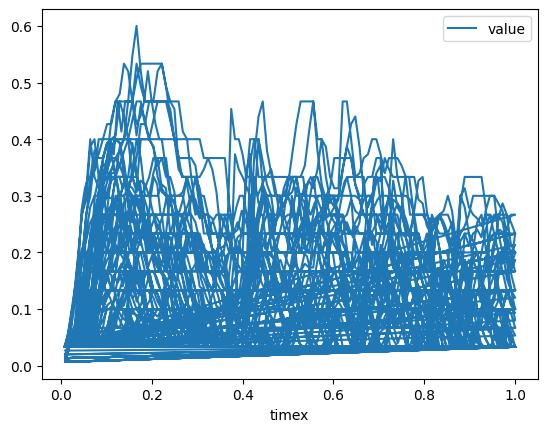

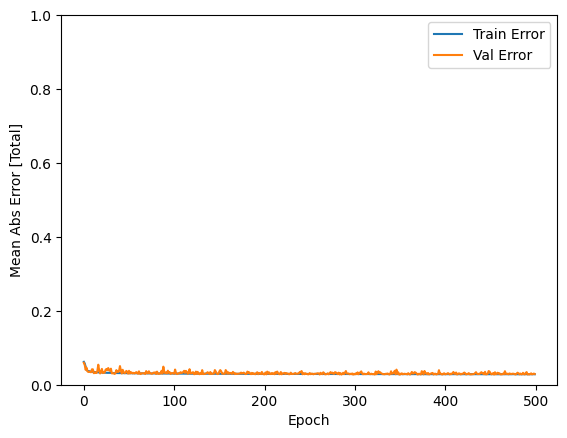

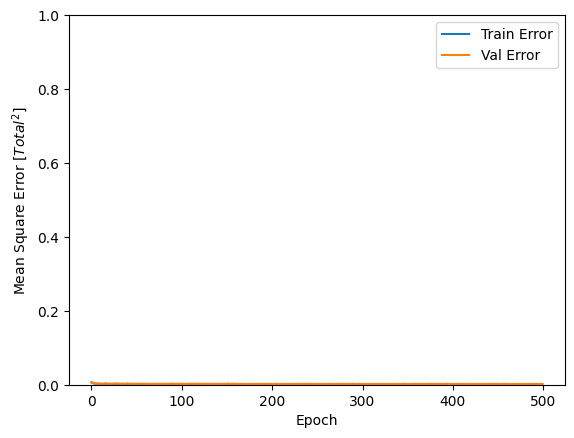

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



.................................................

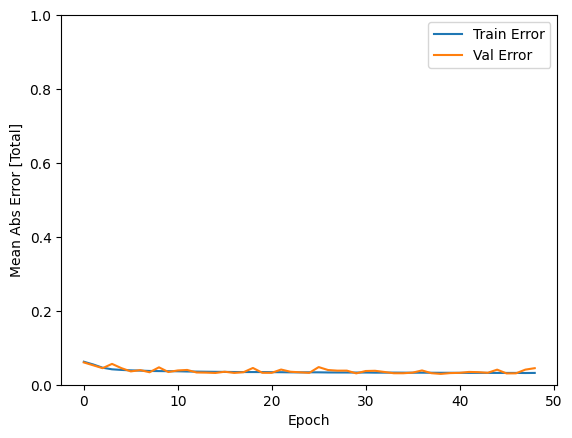

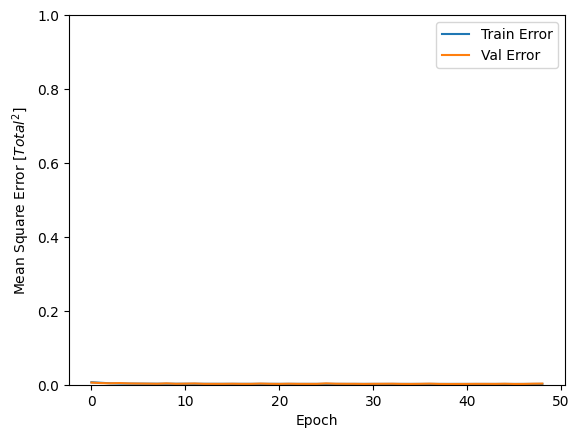

   timex  avg
0   0.01  0.9
1   0.02  0.9
2   0.03  0.9
3   0.04  0.9
4   0.05  0.9
4/4 [==============================] - 0s 1ms/step
[0.08192872 0.10915305 0.13725387 0.16540195 0.19423619 0.22307062
 0.2519009  0.28070414 0.30950755 0.33657444 0.3499068  0.34792924
 0.34473836 0.34096175 0.33679986 0.33245146 0.328103   0.32349777
 0.31771186 0.311926   0.3061401  0.30035424 0.29456842 0.28878248
 0.28299665 0.27721065 0.27131686 0.2633124  0.25546184 0.24793446
 0.2404072  0.23276612 0.22687784 0.22464655 0.22241521 0.2207176
 0.21963741 0.21858379 0.21753006 0.21647635 0.21558732 0.2147473
 0.21390718 0.2141301  0.21595684 0.21774526 0.21949326 0.22124131
 0.22298932 0.22473738 0.22648542 0.22823344 0.22998151 0.23172954
 0.23347756 0.23522556 0.23570561 0.23401949 0.23178998 0.22956046
 0.22733085 0.2250099  0.22268498 0.22036016 0.21803519 0.21571034
 0.2133854  0.21106054 0.20873564 0.20641077 0.2040859  0.20176096
 0.1994361  0.19707191 0.19468161 0.19229123 0.18990076 0.18751

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

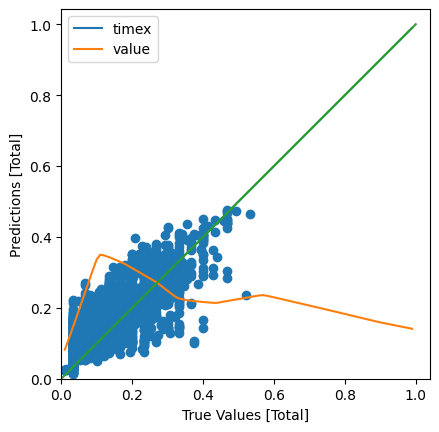

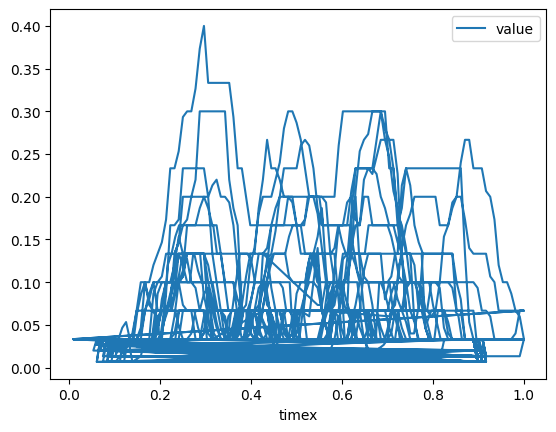

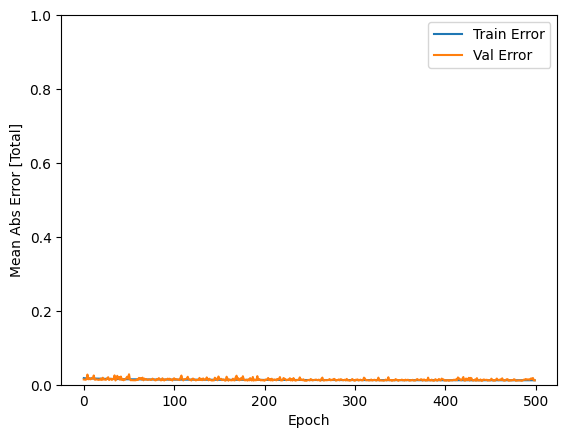

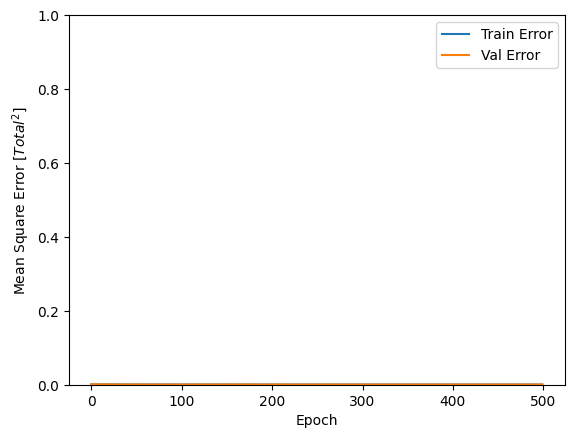

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



.........................................................................

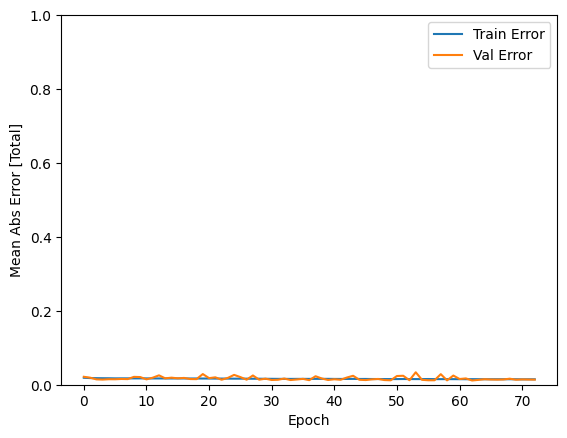

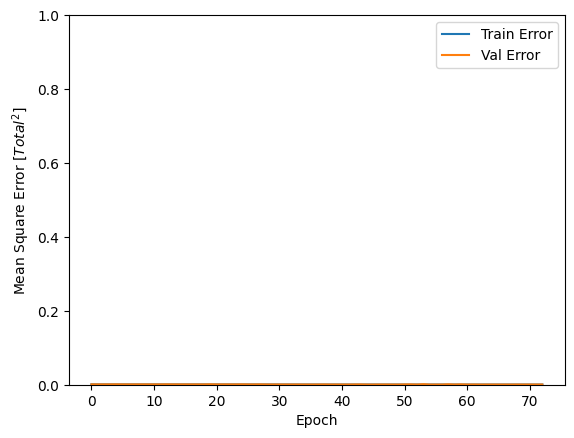

   timex  avg
0   0.01  0.9
1   0.02  0.9
2   0.03  0.9
3   0.04  0.9
4   0.05  0.9
4/4 [==============================] - 0s 993us/step
[0.01323305 0.01389432 0.01450625 0.01516714 0.01592433 0.01703893
 0.01815352 0.01926815 0.02044474 0.02188803 0.02393669 0.02595161
 0.02792422 0.03043701 0.03294978 0.03546281 0.03797666 0.04049053
 0.04277629 0.0449524  0.04712854 0.04930468 0.05148081 0.05365697
 0.05583309 0.05776555 0.05873176 0.05862687 0.058522   0.05865957
 0.05921698 0.0597744  0.06023462 0.06053247 0.0608303  0.06112812
 0.06148571 0.06167048 0.06158278 0.06156015 0.06155753 0.061375
 0.06108144 0.06078786 0.06050208 0.06023657 0.05997108 0.05970561
 0.05944011 0.05917463 0.05892038 0.05867043 0.05843631 0.05821226
 0.05798821 0.05776413 0.05754009 0.05731601 0.05709486 0.05689016
 0.05665854 0.05630945 0.05594377 0.05547515 0.05500229 0.05450399
 0.05388334 0.0533105  0.05277709 0.05224366 0.05171026 0.05115235
 0.05057015 0.04998792 0.04921545 0.04830633 0.0471984  0.045

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

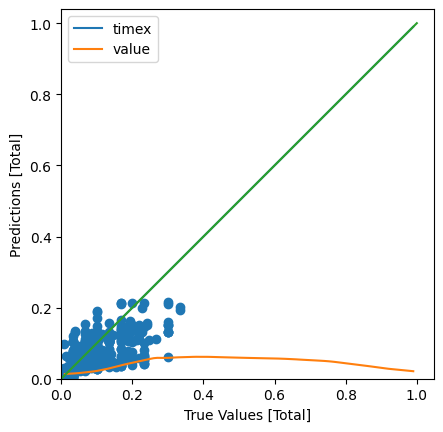

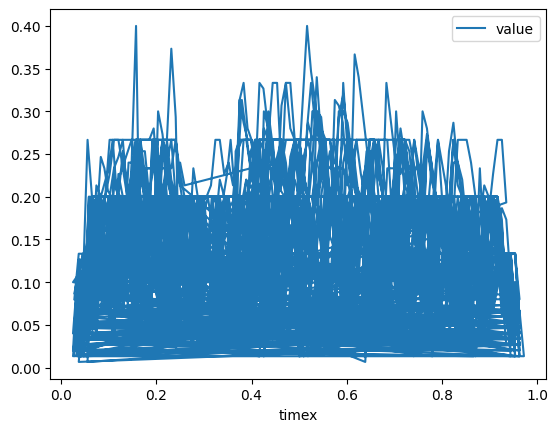

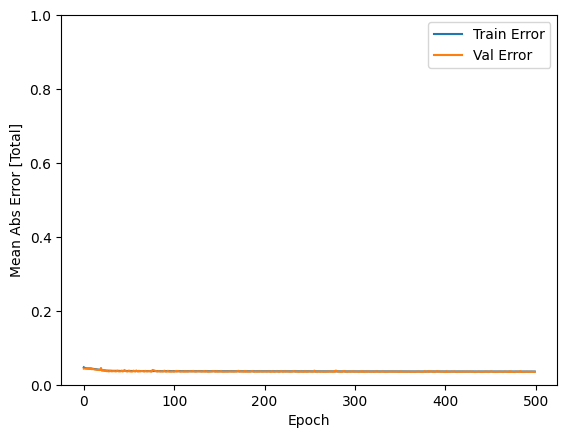

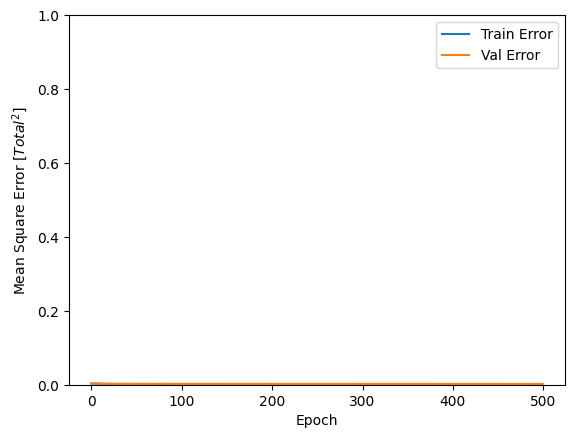

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



......................................................................

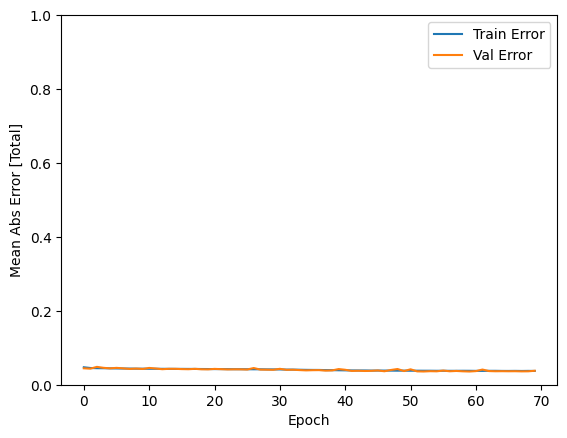

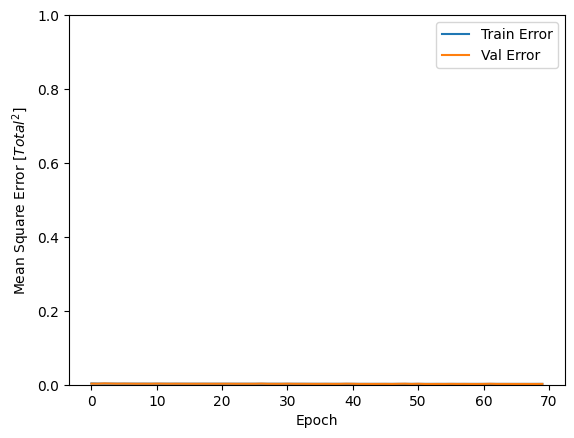

   timex  avg
0   0.01  0.9
1   0.02  0.9
2   0.03  0.9
3   0.04  0.9
4   0.05  0.9
4/4 [==============================] - 0s 1ms/step
[0.02093443 0.03711801 0.05404969 0.07190268 0.08982235 0.10778269
 0.12532702 0.14277476 0.1568672  0.16061878 0.16247192 0.16317466
 0.16387738 0.1645801  0.16528283 0.16598554 0.16668831 0.1672745
 0.16784462 0.1669175  0.1658802  0.16488959 0.16401017 0.16313805
 0.16226591 0.16139382 0.16052164 0.15964954 0.15877737 0.15800935
 0.15752944 0.15704957 0.15679741 0.15671313 0.15694028 0.15756346
 0.15826216 0.15896085 0.15966094 0.16036509 0.16106927 0.16177341
 0.16247758 0.16318172 0.16388476 0.16458654 0.16528833 0.16590078
 0.16642222 0.16694342 0.16746464 0.1679858  0.1681569  0.16829789
 0.1684389  0.16841735 0.1681159  0.16781443 0.16741973 0.16700897
 0.16659819 0.16618764 0.16577749 0.16536732 0.16495717 0.164547
 0.16413689 0.16372669 0.16331655 0.16103455 0.15760751 0.15378082
 0.14995408 0.1461274  0.14230071 0.138474   0.13477129 0.131145

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

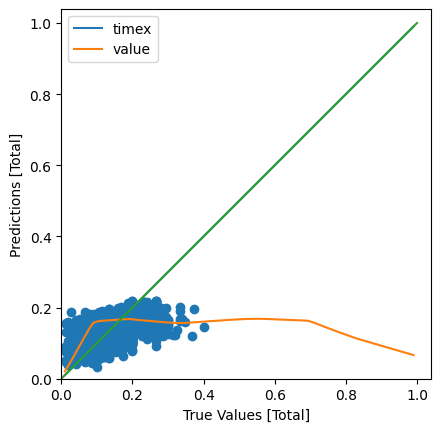

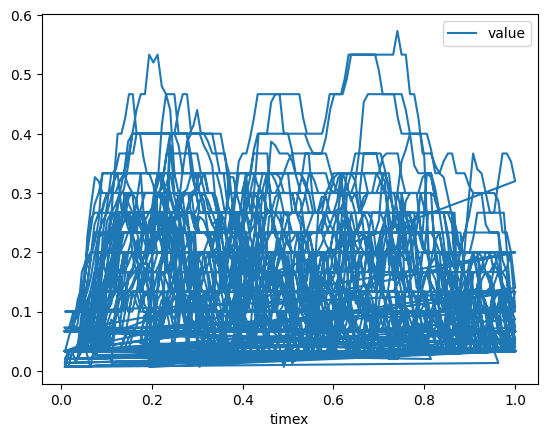

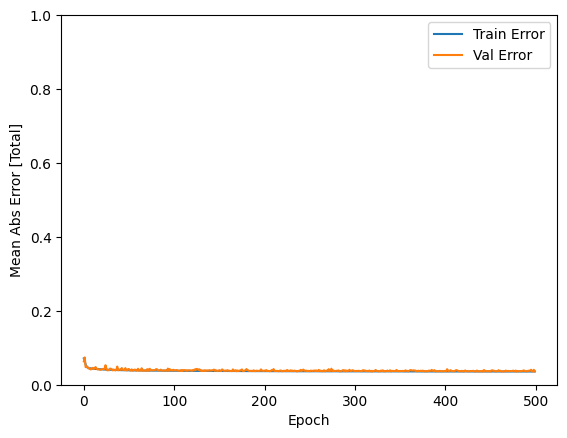

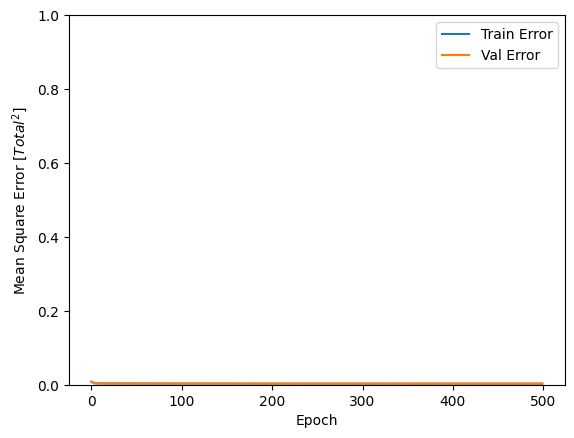

/Users/fanbokong/Library/Python/3.9/lib/python/site-packages/keras/engine/data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]



.........................................

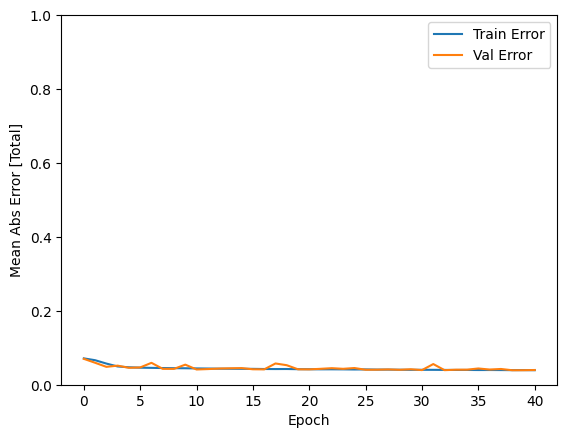

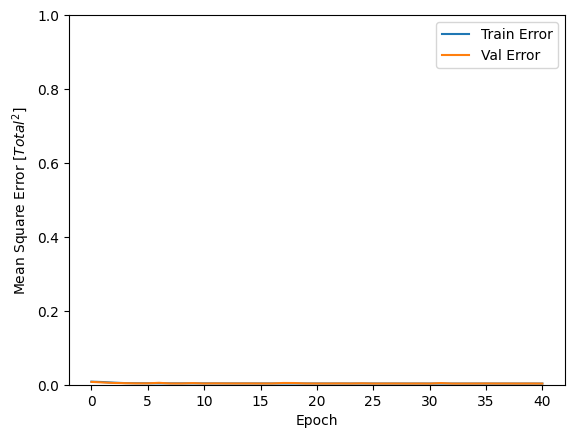

   timex  avg
0   0.01  0.9
1   0.02  0.9
2   0.03  0.9
3   0.04  0.9
4   0.05  0.9
4/4 [==============================] - 0s 1ms/step
[0.04801562 0.06301349 0.07842572 0.09465678 0.11115567 0.12861545
 0.14607535 0.16353515 0.18099496 0.19845471 0.21373063 0.22303256
 0.23187476 0.2380302  0.23939282 0.24065228 0.24177241 0.24276274
 0.24375315 0.24319671 0.24215616 0.24064341 0.23791176 0.23415488
 0.23039809 0.22664127 0.22288448 0.21912757 0.2153708  0.21161391
 0.2078571  0.20410028 0.20034344 0.196601   0.19502604 0.19466136
 0.19429663 0.1939319  0.19356723 0.19337946 0.19325987 0.19312958
 0.19299681 0.19286408 0.19278538 0.19278757 0.19275925 0.19273087
 0.19270256 0.19267577 0.19263032 0.19257462 0.19251886 0.19245286
 0.19213286 0.19181289 0.1914929  0.19117293 0.19085291 0.19053294
 0.19021297 0.18989298 0.18957299 0.18925302 0.18893306 0.18861303
 0.18829305 0.18780167 0.18723473 0.18666777 0.18516663 0.1836062
 0.1816388  0.17926702 0.17640014 0.17334644 0.16969427 0.1660

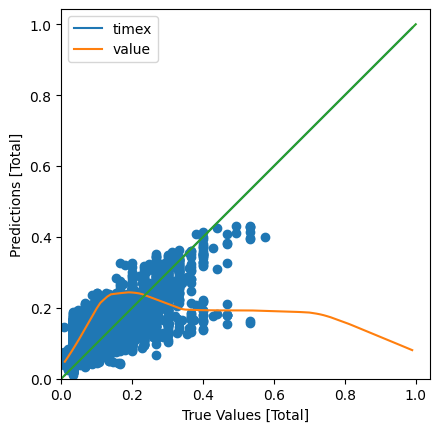

In [20]:
atts = [
  # 'attSoaringOverHorizon;entityType=Attraction;destination=shdr',
  # 'attSevenDwarfsMineTrain;entityType=Attraction;destination=shdr',
  # 'attRoaringRapids;entityType=Attraction;destination=shdr',
  # 'attPiratesOfCaribbean;entityType=Attraction;destination=shdr',

  # 'attTronLightcyclePowerRun;entityType=Attraction;destination=shdr',
  # 'attJetPacks;entityType=Attraction;destination=shdr',
  # 'attBuzzLightyearPlanetRescue;entityType=Attraction;destination=shdr',

  # 'attRexsRCRacer;entityType=Attraction;destination=shdr',
  # 'attSlinkyDogSpinentityType=Attraction;destination=shdr', ##
  # 'attWoodysRoundUp;entityType=Attraction;destination=shdr',
  # 'attHunnyPotSpin;entityType=Attraction;destination=shdr',

  # 'attAdventuresWinniePooh;entityType=Attraction;destination=shdr',
  # 'attVoyageToCrystalGrotto;entityType=Attraction;destination=shdr',
  # 'attPeterPansFlight;entityType=Attraction;destination=shdr',
  # 'attExplorerCanoes;entityType=Attraction;destination=shdr',

  # 'attChallengeTrails;entityType=Attraction;destination=shdr',
  # 'attFantasiaCarousel;entityType=Attraction;destination=shdr',
  # 'attDumboFlyingElephant;entityType=Attraction;destination=shdr',
  # 'attOnceUponTimeAdventure;entityType=Attraction;destination=shdr',

  # '5fa247615ba7f1491f6289a2;entityType=Attraction;destination=usb',
  # '5fa22624dcb5e53c6c72ab42;entityType=Attraction;destination=usb',
  # '5f914afc26509774c642cf42;entityType=Attraction;destination=usb',
  # '5f913de126509774c642cf36;entityType=Attraction;destination=usb',

  # '5f912fd8d72a471ef6359d02;entityType=Attraction;destination=usb',
  # '6121b15723ccd253665b6822;entityType=Attraction;destination=usb',
  # '611f0913e291ec2b16214a88;entityType=Attraction;destination=usb',
  # '60f97e7286449732e736681c;entityType=Attraction;destination=usb',
  # '60f97dfceb33e120fe66fc3e;entityType=Attraction;destination=usb',
  # '60f976da05482c2ea6737a9c;entityType=Attraction;destination=usb',
  # '5fa24b84b9227045895c7495;entityType=Attraction;destination=usb',
  # '5fa23cdcbbdbd416ae43dc05;entityType=Attraction;destination=usb',
  # '5fa22dab40a74131c80b8a72;entityType=Attraction;destination=usb',
  # '5f9161f64b89d447253b02c5;entityType=Attraction;destination=usb',
  # '5f91438e16d92d317523b6a4;entityType=Attraction;destination=usb',
  # '5f8812ec14ae8a2d80450794;entityType=Attraction;destination=usb'
]

for name in atts:
  start(name)
# start('attSoaringOverHorizon;entityType=Attraction;destination=shdr')